Libraries to import

In [ ]:
# Standard library imports
import copy
import json
import pickle
import random
import time
from collections import Counter
from itertools import product
from math import ceil, log10

# Third-party data processing
import numpy as np
import pandas as pd

# PySpark
import pyspark
import pyspark.sql.functions as f

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Machine Learning - sklearn
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# Scientific computing
from scipy.interpolate import interp1d

# MLflow
import mlflow

# Other
from kneed import KneeLocator

Remove unwanted warnings

In [481]:
from warnings import simplefilter
simplefilter(action='ignore')

Useful functions for display

In [482]:

def users_per_permissions(binary_matrix, sorting=True) :
    U = binary_matrix.shape[0]
    if sorting : 
        return binary_matrix.sum(axis=0).sort_values(ascending=True, ignore_index=True).divide(U).multiply(100)
    return binary_matrix.sum(axis=0).divide(U).multiply(100)

def permissions_per_users(binary_matrix, sorting=True) :
    P = binary_matrix.shape[1]
    if sorting :
        return binary_matrix.sum(axis=1).sort_values(ascending=True, ignore_index=True).divide(P).multiply(100)
    return binary_matrix.sum(axis=1).divide(P).multiply(100)


def normalized_users_per_permission(binary_matrix):
    upp = users_per_permissions(binary_matrix).reset_index()
    upp.columns = ['permission_index', 'user_percent']
    upp['permission_index'] /= upp['permission_index'].max()
    upp['permission_index'] *= 100
    upp.columns = ['permission_percent', 'user_percent']
    return upp

def normalized_permissions_per_user(binary_matrix):
    ppu = permissions_per_users(binary_matrix).reset_index()
    ppu.columns = ['user_index', 'permission_percent']
    ppu['user_index'] /= ppu['user_index'].max()
    ppu['user_index'] *= 100
    ppu.columns = ['user_percent', 'permission_percent']
    return ppu

def display_distributions(UPA):
    upp = users_per_permissions(UPA, sorting=True)
    fig = plt.figure(figsize=(7,7))
    ax = upp.plot()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
    plt.grid(True)
    plt.title('Share of users per permission')

    ppu = permissions_per_users(UPA)
    fig = plt.figure(figsize=(7,7))
    ax = ppu.plot()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
    plt.grid(True)
    plt.title('Share permissions per user')

def plot_TSNE_with_labels(TSNE_proj_2d_pd, tab_id_label_pd, sorted_label_list) :

    # Forming the labelled plot
    labelled_plot = pd.concat([tab_id_label_pd, TSNE_proj_2d_pd], axis=1) # Giving back context columns
    number_of_distinct_labels = len(sorted_label_list)

    # Defining colors
    color_list = color_list = ['black', 'red','blue','green','gold', 'magenta', 'darkorange','turquoise' , 'sienna', 'purple', 'lime', 'blueviolet', 'dimgrey', 'navy', 'deepskyblue', 'darkred', 'silver', 'steelblue', 'darkolivegreen', 'plum', 'olive', 'maroon', 'teal', 'peru', 'rebeccapurple', 'crimson', 'darkmagenta' ]
    if number_of_distinct_labels <= len(color_list) :
        color_map = dict(zip(sorted_label_list, color_list[:number_of_distinct_labels]))
    else :
        base =  plt.cm.viridis
        colors = base(np.linspace(0,1,number_of_distinct_labels))
        color_map = dict(zip(sorted_label_list, colors))

    # Create figure
    fig,ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)

    # Scatter points
    for index, row in labelled_plot.iterrows():
        scatter = plt.scatter(row['x'],row['y'], color=color_map[row['cluster_id']], label=int(row['cluster_id']), s=5)

    # Handle legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    by_label = dict(sorted(by_label.items(), key=lambda x: int(x[0]))) # for alphabetical order
    plt.legend(by_label.values(),by_label.keys(), loc='center left', bbox_to_anchor=(1,0.5))

    # Naming
    plt.axis('equal')
    plt.xlabel('X-Axis')
    plt.ylabel('Y-Axis')
    plt.title('TSNE 2D projetction of identities colored by cluster')

    # Display
    plt.show()

# USAGE
# TSNE plot, serves no purposes but allows to see if we did a fairly good job at clustering
# tsne_proj_2d = compute_tsne(tsvd_proj)
# tsne_proj_2d_pd = pd.DataFrame(tsne_proj_2d, columns=['x','y'])
# plot_TSNE_with_labels(tsne_proj_2d_pd, DB_tab_id_label_pd, DB_sorted_cluster_list)

# Function Definitions

## Dataset generation

Tree Class definition 

In [483]:
class Tree:
  def __init__(self, name, children=None, permissions=None) :
    self.name = name
    self.children = []
    self.permissions = []

    if children is not None :
      for child in children :
        self.addChild(child)

    if permissions is not None :
      for permission in permissions :
        self.addPermission(permission)

  def __repr__(self) :
    return self.name
  
  # Modification methods
  def addChild(self, node) :
    assert isinstance(node, Tree)
    self.children.append(node)
  
  def addPermission(self, permission) :
    self.permissions.append(permission)
  
  def addPermissions(self, permission_list) :
    for permission in permission_list :
      self.permissions.append(permission)
  

  # Getter methods
  def get_n_leafs(self):
    if isinstance(self, LeafNode) :
      return(1)
    
    return sum(child.get_n_leafs() for child in self.children)

  def get_n_nodes(self):
    return(1 + sum(child.get_n_nodes() for child in self.children))

  def get_leaf_name_list(self):
    if isinstance(self, LeafNode) :
      return [self.name]
    
    L=[]
    for child in self.children :
      L.extend(child.get_leaf_name_list())
    
    return L

  def get_node_name_list(self):
    L = []
    def traverse(n) :
      L.append(n.name)
      for child in n.children :
        traverse(child)
    traverse(self)
    return L
  
  # Display methods
  def display(self, level = 0) :
    if isinstance(self, LeafNode) :
      print("   " * level + "- " + self.name  + ", P : " + str(self.permissions) + ", U : " + str(self.users))
    else :
      print("   " * level + "- " + self.name + ", P : " + str(self.permissions))
    for child in self.children :
      child.display(level + 1)

  def displayNumbers(self, level = 0) :
    if isinstance(self, LeafNode) :
      print("   " * level + "- " + self.name  + ", P : " + str(len(self.permissions)) + ", U : " + str(len(self.users)))
    else :
      print("   " * level + "- " + self.name + ", P : " + str(len(self.permissions)))
    for child in self.children :
      child.displayNumbers(level + 1)

class LeafNode(Tree):
  def __init__(self, name, users=None) :
    super().__init__(name, children=None, permissions=None)
    self.users = []
    if users is not None :
      for user in users :
        self.addUser(user)
  
  def addChild(self, node) :
    raise Exception("Leaf node cannot have children")
  
  def addUser(self, user):
    self.users.append(user)
  
  def addUsers(self, user_list):
    for user in user_list :
      self.users.append(user)

# Returns a list of (list of users, list of permissions) that are in the tree
def DFS_collect(node, inherited_permissions = None):
  assert isinstance(node, Tree)
  # Base case at the root
  if inherited_permissions is None :
    inherited_permissions = set()
  
  # Get all the permissions at the current level
  current_permissions = inherited_permissions.union(node.permissions)

  # LeafNode case
  if isinstance(node, LeafNode) :
    # users have the set of permissions 
    return [(node.users, current_permissions)]
  
  # General case to traverse the tree
  results = []
  for child in node.children :
    results.extend(DFS_collect(child, current_permissions))
  
  return results

# Primary Tree modifiers
def add_permissions(node, node_name, permission_list):
  assert isinstance(node, Tree)
  if node.name == node_name :
    node.addPermissions(permission_list)
    return True
  
  for child in node.children :
    if add_permissions(child, node_name, permission_list) :
      return True
  
  return False

def add_users(node, leaf_name, user_list):
  assert isinstance(node, Tree)
  if (node.name == leaf_name) and isinstance(node, LeafNode):
    node.addUsers(user_list)
    return True
  
  for child in node.children :
    if add_users(child, leaf_name, user_list) :
      return True
  
  return False

Methods to generate the legitimate permission tree

In [484]:
def generate_tree_with_entropy(min_depth, max_depth, avg_branching, std_dev, min_children, max_children, depth = 0, value = ""):

    # Linear decay between min_depth and max_depth
    def should_expand(depth):
        if depth < min_depth :
            return True
        if depth > max_depth :
            return False
        else:
            return random.random() < (max_depth - depth)/(max_depth - min_depth)
    
    # Number of children chosen based on normal distribution
    def num_children():
        return max(min_children, min(max_children, int(np.random.normal(loc=avg_branching, scale=std_dev))))
    
    # Tree generation
    if should_expand(depth) :
        node = Tree(value + "D" + str(depth))
        num_children = num_children()
    else :
        node = LeafNode("D" + str(depth) + value + "L")
        return node

    for c in range(num_children) :
        child = generate_tree_with_entropy(min_depth, max_depth, avg_branching, std_dev, min_children, max_children, depth+1, value + "D" + str(depth) + "c" + str(c) )
        node.addChild(child)
    
    return node

Function to fill the tree structure with users and permissions

In [485]:
def pop_n_elements(lst, n):
    popped_elements =  lst[:n]
    del lst[:n]
    return popped_elements

# Defintion of function to fill the tree with permissions and users
def fill_tree(root, user_target, legitimate_permission_target):
    N_leaf = root.get_n_leafs()
    N_node = root.get_n_nodes()
    u = user_target//N_leaf                  # Approximation of the number of users per leaf
    p = legitimate_permission_target//N_node # Approximation of the number of permissions per node

    # Actual numbers (users per leafs and permissions per nodes) are chosen on binomial distribution
    L_u = np.random.binomial(2*u , 0.5, size = N_leaf)
    L_p = np.random.binomial(2*p , 0.5, size = N_node)

    # Compute the actual totals of users and permissions
    number_of_users = sum(L_u)
    number_of_legitimate_permissions = sum(L_p)

    # Creating the lists of users and permissions
    Users = list(range(1, number_of_users+1))
    Permissions = list(range(1, number_of_legitimate_permissions+1))
    # Copies to keep track of used permissions
    Users_ = Users.copy()
    Permissions_ = Permissions.copy()

    # Retrieving the nodes and leafs names to assign users and permissions
    leaf_name_list = root.get_leaf_name_list()
    node_name_list = root.get_node_name_list()

    # Assigning permissions to nodes and users to leafs based on generated distribution
    for i in range(N_node):
        add_permissions(root, node_name_list[i], pop_n_elements(Permissions_, L_p[i]))
    for j in range(N_leaf):
        add_users(root, leaf_name_list[j], pop_n_elements(Users_, L_u[j]))
    
    return (Users, Permissions)


Function to add transverse permissions on the UPA

In [486]:
def add_transverse_permissions(node, number_transverse_instances, min_nodes, max_nodes, min_transverse_permissions, max_transverse_permissions, permissions_variable) :
    node_name_list = node.get_node_name_list()
    for i in range(number_transverse_instances) :
        # Get the number of nodes that will share permissions
        n_nodes = random.randint(min_nodes,max_nodes)
        # Sample n_nodes names from tree
        nodes = random.sample(node_name_list, n_nodes)
        # Get the permissions that are shared between them
        n_permissions = random.randint(min_transverse_permissions,max_transverse_permissions)
        perm_list = list(range(permissions_variable[-1]+1, permissions_variable[-1] + n_permissions+1))
        permissions_variable.extend(perm_list)
        # Add the assignations to the tree
        for n in nodes :
            add_permissions(node, n, perm_list)


Functions to add privilege creep

In [487]:
# Function to create complete PC instances
def create_complete_PC_instances(attributions, n_PC_instances):
    complete_PC_attributions = []
    record = []
    detailed_record = []
    for i in range(n_PC_instances) :
        # Choose 2 user domains at random
        r = random.sample(attributions, 2)
        # Pick one user in the first sampled domain
        anomaly = random.sample(r[0][0],1)
        # Add them to record
        record.append(anomaly[0])
        detailed_record.append((anomaly[0], 1))
        # Compute the privilege crept permissions from the second user domain (all permissions are added)
        PC_permissions = r[1][1].difference(r[0][1])
        # Add them to the privilege creep record
        complete_PC_attributions.append((anomaly, PC_permissions))

    return complete_PC_attributions, record, detailed_record

# Function to create partial PC (subset of permissions) instances
def create_partial_PC_instances(attributions, n_PC_partial_instances):
    # linearly decaying distribution for the number of partial instances
    factor_list = [1-1/n_PC_partial_instances*i for i in range(0,n_PC_partial_instances)]
    assert (n_PC_partial_instances == len(factor_list))
    # return variables
    partial_PC_attributions = []
    record = []
    detailed_record = []
    for i in range(n_PC_partial_instances) :
        # Choose 2 user domains at random
        r = random.sample(attributions, 2) #Attention
        # Pick one user in the first sampled domain
        anomaly = random.sample(r[0][0],1) #Attention
        # Add anomaly to record
        record.append(anomaly[0])
        detailed_record.append((anomaly[0],2,factor_list[i]))
        # Compute the privilege crept permissions from the second user domain (partially added)
        PC_permissions = r[1][1].difference(r[0][1])
        PC_partial_permissions = random.sample(sorted(PC_permissions), ceil(len(PC_permissions)*factor_list[i])) #Attention
        partial_PC_attributions.append((anomaly, PC_permissions))

    return partial_PC_attributions, record, detailed_record

# Instances of added permisisons (temporary project)
def create_temporary_project_instances(permissions_list, user_list, list_TP_instances):
    TP_attributions = []
    record = []
    detailed_record = []
    # Span across multiple project sizes
    for index, proj in enumerate(list_TP_instances) :
        # Choose common project permissions
        n_project_permissions = random.randint(50, 80)
        project_permissions = set(list(range(permissions_list[-1]+1, permissions_list[-1] + n_project_permissions+1)))
        permissions_list.extend(project_permissions)

        # Pick users for the project at random
        r = random.sample(user_list, proj)
        for u in r:
            TP_attributions.append(([u], project_permissions))
            record.append(u)
            detailed_record.append((u,3, index))

    return TP_attributions, record, detailed_record


Function to create binary matrices and add PC

In [488]:
# Create binary matrix of legitimate permissions and adding privilege creep afterwards
def generate_legitimate_matrix(tree, Users, Permissions, collected_legitimate_up) :
    # Create void UPA matrix
    legitimate_UPA = pd.DataFrame(0, index=Users, columns=Permissions)

    # Collect legitimate permissions from the tree
    # collected_legitimate_up = DFS_collect(tree)

    # Fill the UPA matrix with the legitimate permissions
    for C in collected_legitimate_up :
        for u in C[0] :
            for p in C[1] :
                legitimate_UPA.at[u, p] = 1
    
    return legitimate_UPA

# Adding the privilege crept permissions to the legitimate matrix
def add_PC_to_UPA(UPA, anomaly_attributions):

    PC_UPA = UPA.copy()

    if len(anomaly_attributions) == 0 :
        return PC_UPA

    # Fill the UPA matrix with the PC permissions
    for C in anomaly_attributions :
        for u in C[0] :
            for p in C[1] :
                PC_UPA.at[u, p] = 1

    return PC_UPA.fillna(0)

Function to add noise on the dataset

In [489]:
# Adding noise in regards to two parameters :
# Noise percentage : give the number of additional attributions based on the number of legitimate ones
# Noise density : gives the density of the final added attributions (number of ones compared to zeros)
# essentially noise density gives the probability that an attribution is mapped to one when looking at 
# one coordinate of the added permission matrix

def add_noise_to_UPA(UPA, legitimate_UP, Legitimate_Perms, Users, noise_on_legitimate=True, noise_parameter_legitimate=0.10, noise_percentage=0.15, noise_density=0.02) :

    noised_UPA = UPA.copy()

    if noise_percentage < 0.0001 :
        return noised_UPA
    
    # Parameters
    n_users = len(Users)
    n_legitimate_perm = int(legitimate_UP.values.sum())
    
    # Noise the legitimate permissions
    if noise_on_legitimate :
        # Get the set of legitimate permissions
        l_permissions = set(Legitimate_Perms)
        # Define the number of noised permissions based on noise parameter
        noise = int(noise_parameter_legitimate * noise_percentage * n_legitimate_perm)
        # Choose the same number of permissions and users to define noised attributions
        all_pairs = list(product(Users, sorted(l_permissions)))
        sampled_pairs = random.sample(all_pairs, noise)
        # Span the list and add the noise to the UPA
        for C in sampled_pairs :
            noised_UPA.at[C[0], C[1]] = 1
        
    # Noise with additional permissions
    # Determine the number of added permissions to be added
    size_perms = n_legitimate_perm * noise_percentage / (noise_density * n_users)
    n_perms = int(size_perms)+1
    #print(n_users*size_perms*noise_density)
    #print(n_legitimate_perm*noise_percentage)

    # Create the new permissions with a Bernouilli experience of probability p=noise_density
    new_perms = np.random.choice([0,1], size=(n_users, n_perms), p = [1-noise_density, noise_density])

    # merging the new added permissions with the UPA matrix
    last_perm = max(UPA.columns)
    column_names = list(range(last_perm + 1, last_perm + 1 + n_perms))
    df = pd.DataFrame(new_perms, columns=column_names, index=Users)
    final_noised_UPA = pd.concat([noised_UPA, df], axis=1)

    return final_noised_UPA


## Dimensionality reduction and clustering

Function for svd compononent search

In [490]:
# Function that computes the TSVD projection of a dataset for increasing
# numbers of components until it finds a value that gets the explained variance above the desired threshold.
# If the threshold is not reached, the function returns the decomposition for 16 components
# If the current explained variance of a component does not exceed 1% we cut of early too

def find_ideal_components_tsvd(data, threshold = 0.75, seed=None, print_details=False) :
    n_comp = 2
    tsvd = TruncatedSVD(n_components=n_comp, algorithm='randomized', n_iter=20, random_state=42)
    tsvd_proj = tsvd.fit_transform(data.to_numpy())
    
    while tsvd.explained_variance_ratio_.sum() < threshold and n_comp < 16 and tsvd.explained_variance_ratio_[-1] > 0.02 :
        n_comp += 1
        tsvd = TruncatedSVD(n_components=n_comp, algorithm='randomized', n_iter=10, random_state=seed)
        tsvd_proj = tsvd.fit_transform(data.to_numpy())
    
        if print_details :
            print("Number of components retained : ", n_comp)
            print("Explained variance attained : ", tsvd.explained_variance_ratio_.sum())
            print("Detail of explained variance : ", tsvd.explained_variance_ratio_)
    
    return tsvd_proj, n_comp, tsvd.explained_variance_ratio_.sum()

def find_ideal_components_tsvd_better(data, threshold = 0.75, seed=None, print_details=False) :
    n_comp = 32
    tsvd = TruncatedSVD(n_components=n_comp, algorithm='randomized', n_iter=20, random_state=42)
    tsvd_proj = tsvd.fit_transform(data.to_numpy())

    list_total_variances = [sum(tsvd.explained_variance_ratio_[0:i+1]) for i in range(0, len(tsvd.explained_variance_ratio_))]

    if print_details :
        print("Number of components retained : ", n_comp)
        print("Explained variance attained : ", tsvd.explained_variance_ratio_.sum())
        print("Detail of explained variance : ", tsvd.explained_variance_ratio_)
        print("Sum of total variances for each additional component : ", list_total_variances)
    
    return tsvd_proj, n_comp, tsvd.explained_variance_ratio_.sum()

def compute_tsvd(data, n_compo, print_details=False) :
    tsvd = TruncatedSVD(n_components=n_compo, algorithm='randomized', n_iter=20, random_state=42)
    tsvd_proj = tsvd.fit_transform(data.to_numpy())
    
    if print_details :
        print("Number of components retained : ", n_compo)
        print("Explained variance attained : ", tsvd.explained_variance_ratio_.sum())
        print("Detail of explained variance : ", tsvd.explained_variance_ratio_)
        
    return tsvd_proj, tsvd.explained_variance_ratio_.sum()

Function to run DBSCAN

In [491]:
def run_dbscan(epsilon, min_s, data, tab_id_pd) :
    # Clustering
    DBclusterer = DBSCAN(eps=epsilon, min_samples=min_s, metric='euclidean', algorithm='auto')
    DBcluster_labels = DBclusterer.fit_predict(data)
    DBsorted_cluster_list = sorted(list(set(DBcluster_labels)))
    # Reconstruct with context
    DBtab_id_label_pd = tab_id_pd
    DBtab_id_label_pd.insert(1,"cluster_id",DBcluster_labels,True)
    return(DBtab_id_label_pd, DBsorted_cluster_list, DBcluster_labels)

In [492]:
def determine_optimal_epsilon_DBSCAN(min_s, svd_proj, plot=False, print_eps=False, skew_factor=1):
    # Compute k-distances
    NN = NearestNeighbors(n_neighbors=min_s+1).fit(svd_proj)
    dist, _ = NN.kneighbors(svd_proj)
    k_dist = np.sort(dist[:, 1])

    # Find elbow in the curve
    kneedle = KneeLocator(range(len(k_dist)), k_dist, curve='convex', direction='increasing')
    optimal_epsilon = k_dist[kneedle.elbow]

    if plot:
        kneedle.plot_knee()
    if print_eps:
        print("Optimal epsilon:", optimal_epsilon)
        print("Skewed epsilon:", optimal_epsilon * skew_factor)

    return optimal_epsilon*skew_factor

In [493]:
def determine_optimal_epsilon_DBSCAN_real_dataset(dataset_name, min_s, svd_proj, plot=False, plot_kneed=False, print_eps=False, skew_factor=1):
    # Compute k-distances
    NN = NearestNeighbors(n_neighbors=min_s+1).fit(svd_proj)
    dist, _ = NN.kneighbors(svd_proj)
    k_dist = np.sort(dist[:, min_s])
    x = list(range(1,len(k_dist)+1))

    # Find elbow in the curve
    kneedle = KneeLocator(range(len(k_dist)), k_dist, curve='convex', direction='increasing')
    optimal_epsilon = k_dist[kneedle.elbow]

    if plot:
        plt.figure()
        plt.plot(x, k_dist, '_',color='black', markersize=4)
        plt.xlabel('user')
        plt.ylabel('1-NN distance')
        title = dataset_name + " : 1-NN TSVD distances on users"
        plt.title(title)
        plt.grid(True)
        plt.legend()
        display(plt.show())
    if plot_kneed :
        kneedle.plot_knee()
    if print_eps:
        print("Optimal epsilon with automatic method :", optimal_epsilon)

    return optimal_epsilon*skew_factor

Alternate methods

In [494]:
# Molloy Method
def step_to_binary(df) :
    return df.applymap(lambda x: 0 if x < 0.5 else 1)

def method_inverse_decomposition(n_comps, data) :
    tsvd = TruncatedSVD(n_components=n_comps, algorithm='randomized', n_iter=10, random_state=None)
    tsvd_proj = tsvd.fit_transform(data.to_numpy())
    raw_projection_pd = pd.DataFrame(tsvd.inverse_transform(tsvd_proj))
    binary_projection_pd = step_to_binary(raw_projection_pd)
    binary_projection_pd.index = data.index
    binary_projection_pd.columns = data.columns
    return step_to_binary(binary_projection_pd)

## Outlier detection and evaluation metrics

Define metrics to measure F1 score for outlier and legitimate

In [495]:
## Implementation of F1 metrics with lists for outlier detection performance evaluation
def list_F1_metrics(real, mined) :
    TP = sum(x in mined for x in real)
    FP = sum(1 for x in mined if x not in real)
    FN = sum(1 for x in real if x not in mined)

    if TP==0 :
        return (FP,FN,0,0,0)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    F1 = 2 * precision * recall / (precision + recall)
    return (FP, FN, precision, recall, F1)

## Better implementation of F1 metrics using pandas to evaluate legitimate permission retention
def list_F1_metrics_pd(True_df, Mined_df) :
    true_df, mined_df = True_df.align(Mined_df, join='outer', axis= None, fill_value=0)
    true_df = true_df.astype(int)
    mined_df = mined_df.astype(int)

    TP = (true_df & mined_df).sum().sum()
    FP = ((~true_df.astype(bool)) & mined_df).sum().sum()
    FN = (true_df & (~mined_df.astype(bool))).sum().sum()

    if TP==0 :
        return (FP,FN,0,0,0)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * (precision * recall) / (precision + recall)

    return(FP, FN, precision, recall, F1)

Define function to clean binary matrix with anomaly list and threshold for each cluster

In [496]:
def clean_binary_matrix(binary_matrix_pd, tab_id_label_pd, anomaly_list, threshold) :
    # Calculate prevalences (share ratio of features within each cluster/label)
    tab_label_features_pd = pd.merge(tab_id_label_pd, binary_matrix_pd, on = 'id', how = 'inner').drop(columns='id')
    tab_label_prevalences_pd = tab_label_features_pd.groupby('cluster_id').mean().reset_index()

    # Set return value : cleaned_matrix
    cleaned_matrix = binary_matrix_pd.copy()
    cleaned_matrix.set_index('id', inplace=True)
    # Remove the outliers
    cleaned_matrix.drop(anomaly_list, inplace=True)

    # Split dataframes into 2 for simplicity
    cluster_ids = tab_label_prevalences_pd.iloc[:, :1]
    feature_prevalences = tab_label_prevalences_pd.iloc[:, 1:]

    # Iterate on feature_prevalences to extract the ones over threshold
    for index, row in feature_prevalences.iterrows():
        # Selects cluster_id
        cluster_id = cluster_ids.iloc[index, 0]                                                
        # Retrieve user list of cluster
        user_list = list(set(tab_id_label_pd[tab_id_label_pd['cluster_id'] == cluster_id]['id'].tolist()))
        # Extracts column names (features) with prevalence < threshold to remove
        feature_list = list(set(feature_prevalences.columns[row.le(threshold)].tolist()))                  
        # Remove the permissions that didn't pass the threshold (Outliers were removed previously)
        if cluster_id != -1 :                                                                   
            cleaned_matrix.loc[user_list, feature_list] = 0
    return(cleaned_matrix)

Function to rebuild the complete UPA like expert knowledge

In [497]:
# Rebuilds a UPA binary matrix with the recommanded features produced by the recommander and the user-id cluster-label match table
def rebuild_cleaned_UPA_pd(tab_id_label_pd, recommandations_pd) :
    merged_pd = tab_id_label_pd.merge(recommandations_pd, on = 'cluster_id')
    binary_matrix = pd.crosstab(merged_pd['id'], merged_pd['feature'])
    return binary_matrix

# Function that seeks the legitimate permissions of the anomalies detected
def seek_anomaly_legitimate_attributions(mined_anomaly_list, legitimate_UPA) :
    filtered_df = legitimate_UPA.astype(int).loc[mined_anomaly_list].astype(int)
    return filtered_df


# Better version
def reintegrate_anomalies(mined_UPA_pd, anomaly_legitimate_pd) :
    all_columns = mined_UPA_pd.columns.union(anomaly_legitimate_pd.columns)

    mined_aligned = mined_UPA_pd.reindex(columns=all_columns, fill_value=0)
    anomaly_aligned = anomaly_legitimate_pd.reindex(columns=all_columns, fill_value=0)

    merged_df = mined_aligned.copy()

    for idx in anomaly_aligned.index:
        if idx in merged_df.index:
            mask = anomaly_aligned.loc[idx] != 0
            merged_df.loc[idx, mask] = anomaly_aligned.loc[idx, mask]
            print("IMPOSSIBLE !!!!!!!!!!!!!!!!!!!!!")
        else:
            merged_df.loc[idx] = anomaly_aligned.loc[idx]

    return merged_df.astype(int)


Define function to remove empty columns

In [498]:
def remove_empty_columns(matrix):
    return matrix.loc[:, (matrix.sum() != 0)]

## Role Mining algorithms

Using the Role Mining algorithms from James Bonifield under the MIT License, available here : https://github.com/jbonifield3/RoleMiner.git

FastMiner Implementation

In [499]:
def FastMiner(UPA) :

    UP = np.unique(np.array(UPA), axis=0).tolist()
    UP = [x for x in UP if x!= [0]*len(x)]

    # Initialize lists
    InitRoles = []
    GenRoles = []
    OrigCount = []
    GenCount = []
    Contributors = []

    for user in UP :
        if sum([user == x for x in InitRoles]) == 0 :
            OrigCount.append(1)
            InitRoles.append(user)
        else :
            pos = [i for i, x in enumerate([user == x for x in InitRoles]) if x][0]
            OrigCount[pos] += 1
    
    InitRoles_iter = InitRoles

    for InitRole in InitRoles_iter :

        # Remove role from InitRoles

        for CandRole in InitRoles_iter :

            NewRole = np.logical_and(list(map(bool,CandRole)),list(map(bool,InitRole))).astype(int).tolist()

            if sum([NewRole == x for x in GenRoles]) == 0 :
                GenCount.append(
                    OrigCount[[i for i, x in enumerate([InitRole == x for x in InitRoles]) if x][0]]
                    + OrigCount[[i for i, x in enumerate([CandRole == x for x in InitRoles]) if x][0]]
                )
                
                Contributors.append([CandRole, InitRole])
                GenRoles.append(NewRole)
    
    return np.array(GenRoles)


OR Implementation

In [500]:
def BasicRMP(UPA, CandRoles, MaxRoles = 200):
    cols = UPA.columns
    UP = np.array(UPA)
    Constraints = np.ones([UP.shape[0], CandRoles.shape[0]], dtype=int)
    OptRoles = []
    iters = 0
    UP_Remain = UP.copy()
    EntitlementCount = []

    for i in range(CandRoles.shape[0]):
        for j in range(UP_Remain.shape[0]):
            # Boolean logic : check if Candidate Role is fully in the User
            # Can be modeled by all elements of the substraction being less than 1
                Constraints[j,i] = (CandRoles[i,:] - UP_Remain[j,:] < 1).all()
    
    while len(OptRoles) < MaxRoles and iters < MaxRoles and np.sum(UP_Remain) > 0 :
        # Determine the Constraints that can be set to zero
        iters += 1 

        # Calculate basic keys
        BasicKeys = []
        i = 0
        for Keys in Constraints.T:
            count = 0

            for C in range(UP_Remain.shape[0]):
                count += Keys[C] * np.sum(np.logical_and(CandRoles[i,:], UP_Remain[C,:])) * (CandRoles[i,:] - UP[C,:] < 1).all()
            BasicKeys.append(count)
            i += 1
        
        # Add Role with the highest Basic Key to OptRoles
        # Break ties by picking with lowest index
        BestRole = CandRoles[np.argmax(BasicKeys)]
        OptRoles.append(BestRole)

        # Delete the Constraints from UP
        for i in range(UP_Remain.shape[0]):
            if (UP[i,:] - BestRole > -1).all():
                UP_Remain[i,:] =  UP_Remain[i,:] - BestRole

                # Map negative numbers to zero (represent roles captured more than once)
                UP_Remain[i,:][UP_Remain[i,:] < 0] = 0
        
        # Set Constraints in Best Role to zero
        Constraints[:,np.argmax(BasicKeys)] = 0
        EntitlementCount.append(np.sum(BestRole))

    # Return New Rules as DF
    OptRoles = pd.DataFrame(data = OptRoles, columns = cols)

    return OptRoles, EntitlementCount

After this part, the implementations are not from James Bonifield

Function that find roles for a user using greedy approach

In [501]:
# Function that find roles for a user using greedy approach
# The algorithm seeks for an exact match
# Cancel the whole thing if it takes more than 10 mins to run

def find_role_assignment(role_matrix, UPA, method):
    user_role_assignment = {}
    user_total = len(UPA.index.to_list())-1
    for index, user_id in enumerate(UPA.index.to_list()) :
        #print("User number : ", index, "/", user_total, end='\r')
        user_perms = UPA.loc[user_id]
        assigned_roles = method(user_perms, role_matrix)
        user_role_assignment[user_id] = assigned_roles
    return user_role_assignment

Auxiliary function that find roles for a user using greedy approach

In [502]:
# Auxiliary function that find roles for a user using greedy approach
# The algorithm seeks for an exact match
# Cancel the whole thing if it takes more than 10 mins to run
def heuristic_find_roles_for_user(user_perms : pd.Series, role_matrix : pd.DataFrame) :
    user_vector =  user_perms.copy()
    roles = role_matrix.copy()

    covered = pd.Series(0, index=user_vector.index)
    selected_roles = []
    remaining_roles = roles.index.to_list()

    while not ((user_vector.astype(bool) & ~covered.astype(bool)).to_numpy().sum()==0):
        best_gain = 0
        best_role = None

        for role in remaining_roles:
            role_vector = roles.loc[role]
            gain = ((user_vector.astype(bool) & ~covered.astype(bool)) & role_vector.astype(bool)).to_numpy().sum()
            if gain > best_gain :
                best_gain = gain
                best_role = role

        if best_role is None :
            return [-1]
        
        covered |= roles.loc[best_role]
        selected_roles.append(best_role)
        remaining_roles.remove(best_role)

    return selected_roles

## Statistics

aligning UPA

In [503]:
def align_upa(upa1, upa2) :
    aligned_upa1, aligned_upa2 = upa1.align(upa2, join="outer", axis=None)
    return aligned_upa1.fillna(0).astype(int), aligned_upa2.fillna(0).astype(int)

In [504]:
# Function that create the user-role assignement matrix
# The algorithm seeks for an exact match so it may take several hours to run
# Cancel the whole thing if it takes more than 10 mins to run

def create_role_user_matrix(user_role_assign, dis = False, dis_json = False) :
    ura = pd.DataFrame.from_dict(user_role_assign, orient='index')
    ura_melted = ura.melt(ignore_index=False).dropna()
    binary_ura = pd.crosstab(ura_melted.index, ura_melted['value'])
    if dis :
        display(binary_ura.reset_index())
    if dis_json :
        print(json.dumps(user_role_assign, indent = 4))
    return binary_ura

Statistics on roles

In [505]:
# Statistics about the roles given to users
def compute_role_stats(rua_matrix) :
    role_stats_RUA = rua_matrix.sum(axis = 1).to_frame().reset_index().set_axis(['role','count (share in users)'], axis = 1)
    return role_stats_RUA

# Statistics about the share of given rolesets among users
def compute_roleset_stats(ura_dict):
    sets = [frozenset(v) for v in ura_dict.values()]
    counter = Counter(sets)
    data = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    roleset_stats = pd.DataFrame(data, columns=['roleset', 'count'])
    return roleset_stats


Statistic share permission retrieved

In [506]:
def share_permission_retrieved(true_upa, mined_completed_upa):
    t_upa, m_upa = align_upa(true_upa, mined_completed_upa)
    r_upa = (t_upa.astype(bool) & m_upa.astype(bool)).astype(int)
    t_norm = true_upa.values.sum()
    r_norm = r_upa.values.sum()
    return(r_norm/t_norm)


Statistic share PC retrieved

In [507]:
# Function that computes the matrix of PC instances only
def only_PC(Legitimate_matrix, PC_matrix) :
  l_matrix, p_matrix = align_upa(Legitimate_matrix, PC_matrix)
  return (p_matrix.astype(bool) & ~l_matrix.astype(bool)).astype(int)

# Function that computes the matrix of retrieved PC given the true PC and the mined UPA
def retrieved_PC(Legitimate_matrix, PC_matrix, Mined_matrix) :
  l_matrix, p_matrix = align_upa(Legitimate_matrix, PC_matrix)
  only_pc_matrix = only_PC(l_matrix, p_matrix)
  m_matrix, o_matrix = align_upa(Mined_matrix, only_pc_matrix)
  retrieved_PC = (o_matrix.astype(bool) & m_matrix.astype(bool)).astype(int)
  return retrieved_PC.astype(int)

# Function that computes the share of PC that is still inside the mined matrix
def compute_share_retrieved_PC(Legitimate_matrix, PC_matrix, Mined_matrix) :
  retrieved_PC_matrix = retrieved_PC(Legitimate_matrix, PC_matrix, Mined_matrix) # aligned inside
  only_PC_matrix = only_PC(Legitimate_matrix, PC_matrix) # aligned inside
  if only_PC_matrix.values.sum() == 0 :
    return 0
  share_retrieved_PC = retrieved_PC_matrix.values.sum() / only_PC_matrix.values.sum()
  return share_retrieved_PC

Debug functions

In [508]:

def duplicate_columns(df) :
    col_counts = df.columns.value_counts()
    duplicate_cols = col_counts[col_counts > 1].index.to_list()
    return (len(duplicate_cols) > 0), duplicate_cols

# Parameter definitions

Parameters for generating legitimate permission trees

In [509]:
TREE_PARAMS = [
    {"nameT": "large_flat"   , "min_child": 2, "max_child": 4, "min_depth": 2 , "max_depth": 4 , "avg_branching": 3  , "std_dev": 1.5},
    {"nameT": "large_string" , "min_child": 1, "max_child": 2, "min_depth": 10, "max_depth": 15, "avg_branching": 1.7, "std_dev": 0.5},
    {"nameT": "binary_tree"  , "min_child": 1, "max_child": 3, "min_depth": 2 , "max_depth": 5 , "avg_branching": 2  , "std_dev": 0},
    {"nameT": "very_random"  , "min_child": 1, "max_child": 6, "min_depth": 2 , "max_depth": 5 , "avg_branching": 2  , "std_dev": 2},
    {"nameT": "little_flat"  , "min_child": 1, "max_child": 5, "min_depth": 1 , "max_depth": 3 , "avg_branching": 3  , "std_dev": 1},
    {"nameT": "little_string", "min_child": 1, "max_child": 2, "min_depth": 5 , "max_depth": 8 , "avg_branching": 1.6, "std_dev": 0.4}
]

Parameters to induce noise and privilege creep on legitimate

In [510]:
NOISE_AND_PC_PARAMS = [
    {"nameN": "no_noise_no_pc"         , "noise_parameter_legitimate": 0.00, "noise_percentage": 0.00, "noise_density": 1.00, 
    "pc_share": -1},
    {"nameN": "low_noise_low_density"  , "noise_parameter_legitimate": 0.10, "noise_percentage": 0.05, "noise_density": 0.01,
    "pc_share": 0.03},
    {"nameN": "high_noise_low_density" , "noise_parameter_legitimate": 0.15, "noise_percentage": 0.15, "noise_density": 0.01,
    "pc_share": 0.05},
    {"nameN": "low_noise_high_density" , "noise_parameter_legitimate": 0.15, "noise_percentage": 0.05, "noise_density": 0.04,
    "pc_share": 0.05},
    {"nameN": "high_noise_high_density", "noise_parameter_legitimate": 0.20, "noise_percentage": 0.20, "noise_density": 0.05, "pc_share": 0.08}
]

Parameters to test the method under stress

In [511]:
# On average
# no on users and permissions : users >= 15*nleafs, perm >= 10*n.nodes
# tension on permissions :      users >= 15*nleafs, perm < 5*n.nodes
# tension on users :            users < 8*nleafs,  perm >= 5*n.nodes
# tension on both :             users < 8*nleafs,  perm < 5*n.nodes
TENSION_PARAMS = [
    {"nameS": "no_tension" , "tension_users":   [15, 25], "tension_perms": [10, 40]},
    {"nameS": "tension_perms", "tension_users": [15, 25], "tension_perms": [2,6]},
    {"nameS": "tension_users", "tension_users": [2,8], "tension_perms":  [10, 40]},
    {"nameS": "tension_both", "tension_users":  [2,8], "tension_perms":   [2,6]}
]

Default parameters used in experimentations

In [512]:
DEFAULT_TENSION_PARAMS = {"nameS": "no_tension" , "tension_users":   [15, 25], "tension_perms": [15, 45]}
DEFAULT_NOISE_PARAMS = {"nameN": "mid_noise_mid_density"  , "noise_parameter_legitimate": 0.10, "noise_percentage": 0.15, "noise_density": 0.02, "pc_share": 0.03}

#print(DEFAULT_TENSION_PARAMS)
#print(DEFAULT_NOISE_PARAMS)

Redundancy in experiments

In [513]:
REDUNDANCY_INT = 20
REDUNDANCY_PARAM = [i for i in range(REDUNDANCY_INT)]
#print(REDUNDANCY_PARAM)

Creating parameters products

In [514]:
PARAM_FIRST_EXPERIMENT = [p1 | p2 | DEFAULT_TENSION_PARAMS | {"redundancy": i} for p1 in TREE_PARAMS for p2 in NOISE_AND_PC_PARAMS for i in REDUNDANCY_PARAM]
PARAM_SECOND_EXPERIMENT = [p1 | p2 | DEFAULT_NOISE_PARAMS | {"redundancy": i} for p1 in TREE_PARAMS for p2 in TENSION_PARAMS for i in REDUNDANCY_PARAM]

#print(json.dumps(PARAM_FIRST_EXPERIMENT, indent = 2))
print("size of parameter set first experiment : ", len(PARAM_FIRST_EXPERIMENT))
#print(json.dumps(PARAM_SECOND_EXPERIMENT, indent = 2))
print("size of parameter set second experiment : ",len(PARAM_SECOND_EXPERIMENT))

size of parameter set first experiment :  600
size of parameter set second experiment :  480


# EXPERIMENTATION

## Dataset validation : explore the distributions

Read and format the real datasets of the literature

In [515]:
# Define dataset names
dataset_names = ['americas_large', 'americas_small', 'apj', 'customer', 'domino', 'emea', 'fire1', 'fire2', 'hc']
base_path = '../../others/datasets/realWorld/csv/'

# Load all datasets into a dictionary
real_datasets_dict = {}
for name in dataset_names:
    df = pd.read_csv(f'{base_path}{name}.csv', sep=',', header=None)
    df = df.set_axis(['user', 'permission'], axis=1)
    # Pivot table to get the binary matrix with 'user' on lines and 'permission' on columns
    binary_matrix = pd.crosstab(df['user'], df['permission'])
    real_datasets_dict[name] = binary_matrix
    print(f"Loaded: {name}")

# Access datasets by name
# display(real_datasets_dict['americas_large'])
# display(real_datasets_dict['apj'])

Loaded: americas_large
Loaded: americas_small
Loaded: apj
Loaded: customer
Loaded: domino
Loaded: emea
Loaded: fire1
Loaded: fire2
Loaded: hc


Run the following to generate several datasets and save the distributions of users and permissions

In [516]:
RUN_DATASET_GEN = False

In [517]:
if RUN_DATASET_GEN :
    
    PARAM_CHOSEN = PARAM_SECOND_EXPERIMENT
    
    if PARAM_CHOSEN == PARAM_FIRST_EXPERIMENT :
        first_exp_dict_users_per_permission = {}
        first_exp_dict_permissions_per_user = {}
        first_exp_unique_dataset_key_list = []
    elif PARAM_CHOSEN == PARAM_SECOND_EXPERIMENT :
        second_exp_dict_users_per_permission = {}
        second_exp_dict_permissions_per_user = {}
        second_exp_unique_dataset_key_list = []
    
    for i, param_set in enumerate(PARAM_CHOSEN):
        ### Initialise parameters
            print("Initialising parameters...")
            par_nameT = param_set["nameT"]
            par_nameN = param_set["nameN"]
            par_nameS = param_set["nameS"]
            par_redundancy = param_set["redundancy"]
            min_child =                  param_set["min_child"]
            max_child =                  param_set["max_child"]
            min_depth =                  param_set["min_depth"]
            max_depth =                  param_set["max_depth"]
            avg_branching =              param_set["avg_branching"]
            std_dev =                    param_set["std_dev"]
            noise_parameter_legitimate = param_set["noise_parameter_legitimate"]
            noise_percentage =           param_set["noise_percentage"]
            noise_density =              param_set["noise_density"]
            pc_share =                   param_set["pc_share"]
            redundancy =                 param_set["redundancy"]
            tension_users =              param_set["tension_users"]
            tension_perms =              param_set["tension_perms"]
            
            ### Generate Data
            ## Generate tree
            print("Generating tree...")
            t = time.time()
            tree = generate_tree_with_entropy(min_depth, max_depth, avg_branching, std_dev, min_child, max_child)
            while tree.get_n_leafs() < 6 :
                tree = generate_tree_with_entropy(min_depth, max_depth, avg_branching, std_dev, min_child, max_child)
            root_source = tree
            n_nodes = tree.get_n_nodes()
            n_leafs = tree.get_n_leafs()

            
            ## Tree filling
            #- Fill with legit permissions
            user_target = n_leafs * random.choice(range(tension_users[0], tension_users[1]+1))
            legitimate_permission_target = n_nodes * random.choice(range(tension_perms[0], tension_perms[1]+1))
            Users, Permissions = fill_tree(root_source, user_target, legitimate_permission_target)
            #- Add transverse permissions
            add_transverse_permissions(node=root_source, number_transverse_instances=3, min_nodes=2, max_nodes=3, min_transverse_permissions=10, max_transverse_permissions=30, permissions_variable=Permissions)
            Legitimate_Permissions = Permissions.copy()
            n_users = len(Users)
            n_legitimate_permissions = len(Legitimate_Permissions)
            
            while n_users < 10 :
                ## Tree filling
                #- Fill with legit permissions
                user_target = n_leafs * random.choice(range(tension_users[0], tension_users[1]+1))
                legitimate_permission_target = n_nodes * random.choice(range(tension_perms[0], tension_perms[1]+1))
                Users, Permissions = fill_tree(root_source, user_target, legitimate_permission_target)
                #- Add transverse permissions
                add_transverse_permissions(node=root_source, number_transverse_instances=3, min_nodes=2, max_nodes=3, min_transverse_permissions=10, max_transverse_permissions=30, permissions_variable=Permissions)
                Legitimate_Permissions = Permissions.copy()
                n_users = len(Users)
                n_legitimate_permissions = len(Legitimate_Permissions)
            
            
            print("Tree generated with : ", n_nodes, "nodes,", n_leafs, "leafs,", n_users, "users,", n_legitimate_permissions, "legitimate permissions")

            ## Insert privilege creep
            print("Injecting privilege creep ...")
            attributions = DFS_collect(root_source)
            if pc_share > 0 :
                anomaly_list = []
                anomaly_list_detail = []
                anomaly_list_without_TP = []
                anomaly_attributions = []
                n_PC_instances = int(pc_share * n_users)+1
                PC_instances = int(0.3*n_PC_instances)+1
                PC_partial_instances = int(0.7*n_PC_instances)+1
                TP_instances = [8 for i in range(int(log10(n_users)))]

                PC_attributions, PC_list, PC_list_detail = create_complete_PC_instances(attributions, PC_instances)
                PC_partial_attributions, PC_partial_list, PC_partial_list_detail = create_partial_PC_instances(attributions, PC_partial_instances)
                TP_attributions, TP_list, TP_list_detail = create_temporary_project_instances(Permissions, Users, TP_instances)

                anomaly_attributions.extend(PC_attributions)
                anomaly_attributions.extend(PC_partial_attributions)
                anomaly_attributions.extend(TP_attributions)

                anomaly_list = sorted(set(PC_list+PC_partial_list+TP_list))
                anomaly_list_detail = sorted(set(PC_list_detail+PC_partial_list_detail+TP_list_detail))
                anomaly_list_without_TP = sorted(set(PC_list+PC_partial_list))
            else :
                n_PC_instances = 0
                PC_instances = 0
                PC_partial_instances = 0
                TP_instances = []
                anomaly_list = []
                anomaly_list_detail = []
                anomaly_list_without_TP = []
                anomaly_attributions = []
                PC_list = []
                PC_partial_list = []
                TP_list = []

            ## Create UPA matrices
            print("Creating UPA matrices ...")
            legitimate_UPA = generate_legitimate_matrix(root_source, Users, Legitimate_Permissions, attributions)
            if pc_share > 0 :
                PC_UPA = add_PC_to_UPA(legitimate_UPA, anomaly_attributions)
            else : 
                PC_UPA = legitimate_UPA.copy()
            noised_UPA = add_noise_to_UPA(UPA=PC_UPA, legitimate_UP=legitimate_UPA, Legitimate_Perms=Legitimate_Permissions, Users=Users, noise_on_legitimate=(noise_parameter_legitimate > 0.001), noise_parameter_legitimate=noise_parameter_legitimate, noise_percentage = noise_percentage, noise_density = noise_density)

            # Verifiy duplicates
            d1,d2,d3 = duplicate_columns(legitimate_UPA), duplicate_columns(PC_UPA), duplicate_columns(noised_UPA)
            if d1[0] or d2[0] or d3[0] :
                print("duplicates legitimate : ", d1[1])
                print("duplicates PC : ", d2[1])
                print("duplicates noised : ", d3[1])
                raise ValueError("Duplicates found in UPA matrices")
            t_dataset_generation = time.time() - t
            
            ppu = normalized_permissions_per_user(noised_UPA)
            upp = normalized_users_per_permission(noised_UPA)
            
            unique_key = f"{par_nameT}_{par_nameS}_{par_nameN}_{par_redundancy}"
            
            if PARAM_CHOSEN == PARAM_FIRST_EXPERIMENT :
                first_exp_dict_users_per_permission[unique_key] = upp
                first_exp_dict_permissions_per_user[unique_key] = ppu
                first_exp_unique_dataset_key_list.append(unique_key)
            elif PARAM_CHOSEN == PARAM_SECOND_EXPERIMENT :
                second_exp_dict_users_per_permission[unique_key] = upp
                second_exp_dict_permissions_per_user[unique_key] = ppu
                second_exp_unique_dataset_key_list.append(unique_key)

File manipulation to save needed datasets

In [518]:
'''
# Save
with open("first_exp_dict_users_per_permission.pkl", "wb") as f:
    pickle.dump(first_exp_dict_users_per_permission, f)
    
# Save
with open("first_exp_dict_permissions_per_user.pkl", "wb") as f:
    pickle.dump(first_exp_dict_permissions_per_user, f)
    
# Save
with open("second_exp_dict_users_per_permission.pkl", "wb") as f:
    pickle.dump(second_exp_dict_users_per_permission, f)
    
# Save
with open("second_exp_dict_permissions_per_user.pkl", "wb") as f:
    pickle.dump(second_exp_dict_permissions_per_user, f)

# Load
with open("first_exp_dict_users_per_permission.pkl", "rb") as f:
    loaded_dict1 = pickle.load(f)
    display(loaded_dict1)
with open("first_exp_dict_permissions_per_user.pkl", "rb") as f:
    loaded_dict2 = pickle.load(f)
    display(loaded_dict2)
with open("second_exp_dict_users_per_permission.pkl", "rb") as f:
    loaded_dict1 = pickle.load(f)
    display(loaded_dict1)
with open("second_exp_dict_permissions_per_user.pkl", "rb") as f:
    loaded_dict2 = pickle.load(f)
    display(loaded_dict2)
'''

'\n# Save\nwith open("first_exp_dict_users_per_permission.pkl", "wb") as f:\n    pickle.dump(first_exp_dict_users_per_permission, f)\n    \n# Save\nwith open("first_exp_dict_permissions_per_user.pkl", "wb") as f:\n    pickle.dump(first_exp_dict_permissions_per_user, f)\n    \n# Save\nwith open("second_exp_dict_users_per_permission.pkl", "wb") as f:\n    pickle.dump(second_exp_dict_users_per_permission, f)\n    \n# Save\nwith open("second_exp_dict_permissions_per_user.pkl", "wb") as f:\n    pickle.dump(second_exp_dict_permissions_per_user, f)\n\n# Load\nwith open("first_exp_dict_users_per_permission.pkl", "rb") as f:\n    loaded_dict1 = pickle.load(f)\n    display(loaded_dict1)\nwith open("first_exp_dict_permissions_per_user.pkl", "rb") as f:\n    loaded_dict2 = pickle.load(f)\n    display(loaded_dict2)\nwith open("second_exp_dict_users_per_permission.pkl", "rb") as f:\n    loaded_dict1 = pickle.load(f)\n    display(loaded_dict1)\nwith open("second_exp_dict_permissions_per_user.pkl", "r

Functions to plot the distributions

In [519]:
def plot_distributions_general(df): 
    # Create square figure
    fig, ax = plt.subplots(figsize=(8, 8))

    col1, col2 = df.columns
    # Plot your data
    ax.plot(df[col1], df[col2])

    # Set both axes to 0-100
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # Make it square
    ax.set_aspect('equal')

    # Labels and title
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)

    # Optional: Add grid
    ax.grid(True, alpha=0.3)

    plt.show()  

Plot the distributions for real datasets

Plot saved to concentration_upp_real_world.pdf


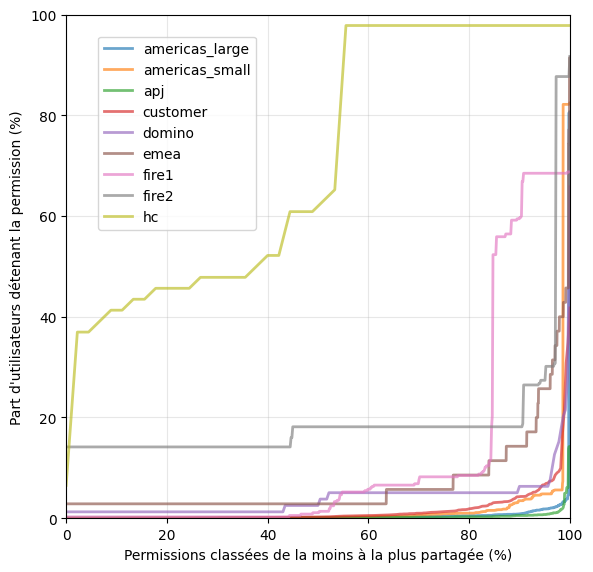

In [520]:
def plot_upp_multiple(datasets_dict, save_path=None):
    # Create square figure
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Define colors for each dataset (optional, for better visibility)
    colors = plt.cm.tab10(range(len(datasets_dict)))
    
    # Plot each dataset
    for (name, df), color in zip(datasets_dict.items(), colors):
        upp = normalized_users_per_permission(df)
        col1, col2 = upp.columns
        ax.plot(upp[col1], upp[col2], label=name, alpha=0.66, color=color, linestyle='-', linewidth=2)
    
    # Set both axes to 0-100
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    
    # Make it square
    ax.set_aspect('equal')
    
    # Labels and title
    ax.set_xlabel('Permissions classées de la moins à la plus partagée (%)')
    ax.set_ylabel('Part d\'utilisateurs détenant la permission (%)')
    #ax.set_title('Courbe de concentration normalisée des permissions\n sur les jeux de données réels')
    
    # Add legend
    ax.legend(bbox_to_anchor=(0.05, 0.97), loc='upper left')
    
    # Optional: Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save or show
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()
    
    plt.close()

# Usage
plot_upp_multiple(real_datasets_dict, save_path="concentration_upp_real_world.pdf")
plot_upp_multiple(real_datasets_dict)

Plot saved to concentration_ppu_real_world.pdf


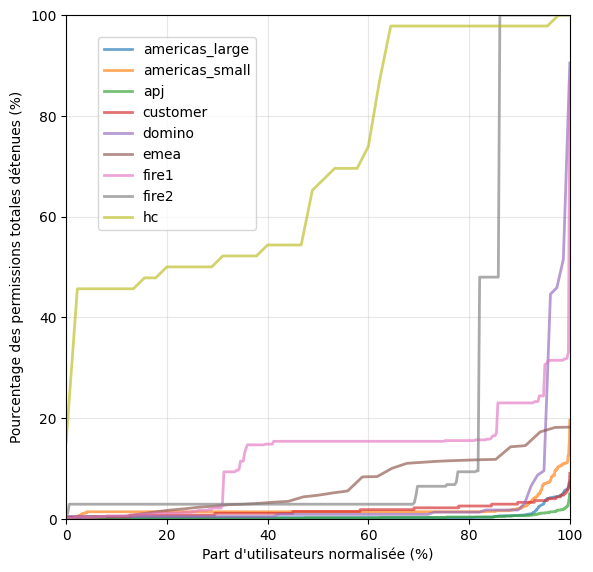

In [521]:
def plot_ppu_multiple(datasets_dict, save_path=None):
    # Create square figure
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Define colors for each dataset (optional, for better visibility)
    colors = plt.cm.tab10(range(len(datasets_dict)))
    
    # Plot each dataset
    for (name, df), color in zip(datasets_dict.items(), colors):
        ppu = normalized_permissions_per_user(df)
        col1, col2 = ppu.columns
        ax.plot(ppu[col1], ppu[col2], label=name, alpha=0.66, color=color, linestyle='-', linewidth=2)
    
    # Set both axes to 0-100
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    
    # Make it square
    ax.set_aspect('equal')
    
    # Labels and title
    ax.set_xlabel('Part d\'utilisateurs normalisée (%)')
    ax.set_ylabel('Pourcentage des permissions totales détenues (%)')
    #ax.set_title('Courbe de concentration normalisée des permissions\nen fonction des utilisateurs sur les jeux de données réels')
    
    # Add legend
    ax.legend(bbox_to_anchor=(0.05, 0.97), loc='upper left')
    
    # Optional: Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save or show
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()
    
    plt.close()

# Usage
plot_ppu_multiple(real_datasets_dict, save_path="concentration_ppu_real_world.pdf")
plot_ppu_multiple(real_datasets_dict)

Plot the median distributions for real datasets

Plot saved to concentration_upp_median_real_world.pdf


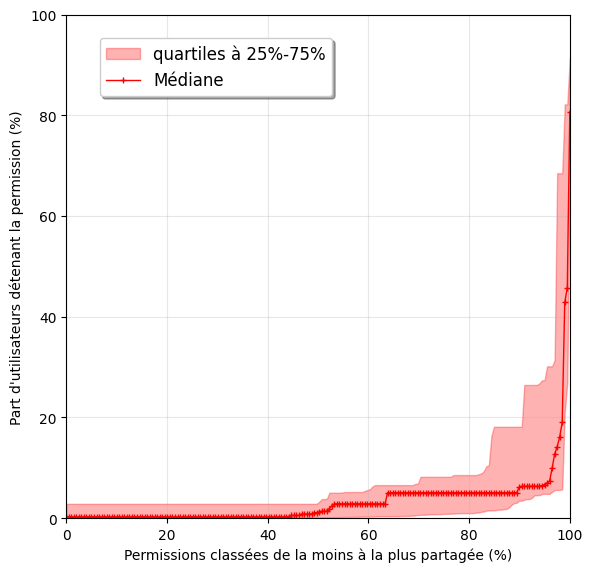

In [539]:
def plot_upp_median_with_envelope_interpolated(datasets_dict, n_points=100, quantiles=[0.25, 0.75], save_path=None):
    """
    Plot the upp median of all datasets with a quantile envelope.
    Interpolates all datasets to the same number of points first.
   
    Args:
        datasets_dict: Dictionary where keys are dataset names and values are dataframes
        n_points: Number of points to interpolate each dataset to
        quantiles: List of quantiles to use for envelope (default: 25th and 75th percentiles)
        save_path: Path to save the PDF file (e.g., 'output.pdf'). If None, displays plot instead.
    """
    # Create square figure
    fig, ax = plt.subplots(figsize=(6, 6))
   
    # Interpolate all datasets to same number of points
    interpolated_data = []
   
    for name, df in datasets_dict.items():
        upp = normalized_users_per_permission(df)
        col1, col2 = upp.columns
       
        x = upp[col1].values
        y = upp[col2].values
       
        # Create interpolation function
        f = interp1d(x, y, kind='linear', fill_value='extrapolate')
       
        # Interpolate to uniform points
        x_uniform = np.linspace(0, 100, n_points)
        y_uniform = f(x_uniform)
       
        # Clip values to 0-100 range
        y_uniform = np.clip(y_uniform, 0, 100)
       
        interpolated_data.append(y_uniform)
   
    # Convert to array (n_datasets x n_points)
    interpolated_data = np.array(interpolated_data)
   
    # Create uniform x axis
    x_uniform = np.linspace(0, 100, n_points)
   
    # Calculate mean and quantiles
    y_mean = np.median(interpolated_data, axis=0)
    y_lower = np.quantile(interpolated_data, quantiles[0], axis=0)
    y_upper = np.quantile(interpolated_data, quantiles[1], axis=0)
   
    # Plot the envelope
    ax.fill_between(x_uniform, y_lower, y_upper,
                     alpha=0.3, color='red', label=f'quartiles à {quantiles[0]*100:.0f}%-{quantiles[1]*100:.0f}%')
   
    # Plot the average line
    ax.plot(x_uniform, y_mean, color='red', linewidth=1, label='Médiane', marker='+', markersize=5)
   
    # Set both axes to 0-100
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
   
    # Make it square
    ax.set_aspect('equal')
   
    # Labels and title
    ax.set_xlabel('Permissions classées de la moins à la plus partagée (%)')
    ax.set_ylabel('Part d\'utilisateurs détenant la permission (%)')
    #ax.set_title('Courbe de concentration médiane des permissions\nsur les jeux de données réels avec enveloppe de quantiles (interpolée)', fontsize=16, fontweight='bold', pad=20)
   
    # Add legend
    ax.legend(bbox_to_anchor=(0.05, 0.97), loc='upper left',
    fontsize=12,           # Taille du texte de la légende
    frameon=True,          # Cadre autour de la légende
    fancybox=True,         # Coins arrondis
    shadow=True)           # Ombre
   
    # Optional: Add grid
    ax.grid(True, alpha=0.3)
   
    plt.tight_layout()
    
    # Save or show
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()
    
    plt.close()

# Save to PDF
plot_upp_median_with_envelope_interpolated(
    real_datasets_dict, 
    n_points=200, 
    quantiles=[0.25, 0.75],
    save_path='concentration_upp_median_real_world.pdf'
)

# Display
plot_upp_median_with_envelope_interpolated(
    real_datasets_dict, 
    n_points=200, 
    quantiles=[0.25, 0.75]
)

Plot saved to concentration_ppu_median_real_world.pdf


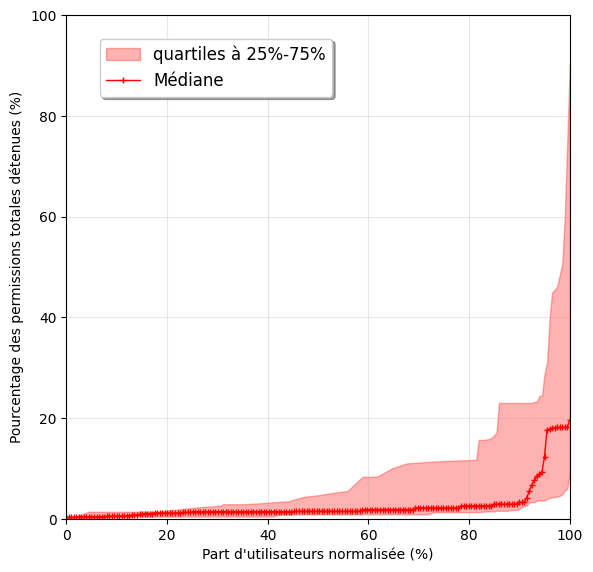

In [540]:
def plot_ppu_median_with_envelope_interpolated(datasets_dict, n_points=100, quantiles=[0.25, 0.75], save_path=None):
    """
    Plot the ppu median of all datasets with a quantile envelope.
    Interpolates all datasets to the same number of points first.
   
    Args:
        datasets_dict: Dictionary where keys are dataset names and values are dataframes
        n_points: Number of points to interpolate each dataset to
        quantiles: List of quantiles to use for envelope (default: 25th and 75th percentiles)
        save_path: Path to save the PDF file (e.g., 'output.pdf'). If None, displays plot instead.
    """
    # Create square figure
    fig, ax = plt.subplots(figsize=(6, 6))
   
    # Interpolate all datasets to same number of points
    interpolated_data = []
   
    for name, df in datasets_dict.items():
        ppu = normalized_permissions_per_user(df)
        col1, col2 = ppu.columns
       
        x = ppu[col1].values
        y = ppu[col2].values
       
        # Create interpolation function
        f = interp1d(x, y, kind='linear', fill_value='extrapolate')
       
        # Interpolate to uniform points
        x_uniform = np.linspace(0, 100, n_points)
        y_uniform = f(x_uniform)
       
        # Clip values to 0-100 range
        y_uniform = np.clip(y_uniform, 0, 100)
       
        interpolated_data.append(y_uniform)
   
    # Convert to array (n_datasets x n_points)
    interpolated_data = np.array(interpolated_data)
   
    # Create uniform x axis
    x_uniform = np.linspace(0, 100, n_points)
   
    # Calculate mean and quantiles
    y_mean = np.median(interpolated_data, axis=0)
    y_lower = np.quantile(interpolated_data, quantiles[0], axis=0)
    y_upper = np.quantile(interpolated_data, quantiles[1], axis=0)
   
    # Plot the envelope
    ax.fill_between(x_uniform, y_lower, y_upper,
                     alpha=0.3, color='red', label=f'quartiles à {quantiles[0]*100:.0f}%-{quantiles[1]*100:.0f}%')
   
    # Plot the average line
    ax.plot(x_uniform, y_mean, color='red', linewidth=1, label='Médiane', marker='+', markersize=5)
   
    # Set both axes to 0-100
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
   
    # Make it square
    ax.set_aspect('equal')
   
    # Labels and title
    ax.set_xlabel('Part d\'utilisateurs normalisée (%)')
    ax.set_ylabel('Pourcentage des permissions totales détenues (%)')
    #ax.set_title('Courbe de concentration médiane des permissions\nsur les jeux de données réels avec enveloppe de quantiles (interpolée)', fontsize=16, fontweight='bold', pad=20)
   
    # Add legend
    ax.legend(bbox_to_anchor=(0.05, 0.97), loc='upper left',
    fontsize=12,           # Taille du texte de la légende
    frameon=True,          # Cadre autour de la légende
    fancybox=True,         # Coins arrondis
    shadow=True)           # Ombre
   
    # Optional: Add grid
    ax.grid(True, alpha=0.3)
   
    plt.tight_layout()
    
    # Save or show
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()
    
    plt.close()

# Save to PDF
plot_ppu_median_with_envelope_interpolated(
    real_datasets_dict, 
    n_points=200, 
    quantiles=[0.25, 0.75],
    save_path='concentration_ppu_median_real_world.pdf'
)

# Display
plot_ppu_median_with_envelope_interpolated(
    real_datasets_dict, 
    n_points=200, 
    quantiles=[0.25, 0.75]
)

Load generated information saved in files if needed

In [ ]:
# Load
with open("first_exp_dict_users_per_permission.pkl", "rb") as f:
    first_exp_dict_users_per_permission = pickle.load(f)
with open("first_exp_dict_permissions_per_user.pkl", "rb") as f:
    first_exp_dict_permissions_per_user = pickle.load(f)
first_exp_unique_dataset_key_list = list(first_exp_dict_permissions_per_user.keys())

# Load
with open("second_exp_dict_users_per_permission.pkl", "rb") as f:
    second_exp_dict_users_per_permission = pickle.load(f)
with open("second_exp_dict_permissions_per_user.pkl", "rb") as f:
    second_exp_dict_permissions_per_user = pickle.load(f)
second_exp_unique_dataset_key_list = list(second_exp_dict_permissions_per_user.keys())

synthetic_dict_users_per_permission = first_exp_dict_users_per_permission | second_exp_dict_users_per_permission
synthetic_dict_permissions_per_user = first_exp_dict_permissions_per_user | second_exp_dict_permissions_per_user

print(len(first_exp_dict_permissions_per_user),
      len(second_exp_dict_permissions_per_user),
      len(synthetic_dict_users_per_permission))

600 480 1080


Function to plot upp and ppu on synthetic datasets

In [525]:
def plot_distributions_median_with_envelope_interpolated(datasets_dict, n_points=100, quantiles=[0.25, 0.75], save_path=None, pattern=None):
    """
    Args:
        datasets_dict: Dictionary where keys are dataset names and values are dataframes
        n_points: Number of points to interpolate each dataset to
        quantiles: List of quantiles to use for envelope (default: 25th and 75th percentiles)
        save_path: Path to save the PDF file (e.g., 'output.pdf'). If None, displays plot instead.
    """
    # Create square figure
    fig, ax = plt.subplots(figsize=(6, 6))
   
    # Interpolate all datasets to same number of points
    interpolated_data = []
   
    if pattern != None:
        filtered_dict = {k: v for k, v in datasets_dict.items() if pattern in k}
    else :
        filtered_dict = datasets_dict
   
    for name, df in filtered_dict.items():
        col1, col2 = df.columns
       
        x = df[col1].values
        y = df[col2].values
       
        # Create interpolation function
        f = interp1d(x, y, kind='linear', fill_value='extrapolate')
       
        # Interpolate to uniform points
        x_uniform = np.linspace(0, 100, n_points)
        y_uniform = f(x_uniform)
       
        # Clip values to 0-100 range
        y_uniform = np.clip(y_uniform, 0, 100)
       
        interpolated_data.append(y_uniform)
   
    # Convert to array (n_datasets x n_points)
    interpolated_data = np.array(interpolated_data)
   
    # Create uniform x axis
    x_uniform = np.linspace(0, 100, n_points)
   
    # Calculate mean and quantiles
    y_mean = np.median(interpolated_data, axis=0)
    y_lower = np.quantile(interpolated_data, quantiles[0], axis=0)
    y_upper = np.quantile(interpolated_data, quantiles[1], axis=0)
   
    # Plot the envelope
    ax.fill_between(x_uniform, y_lower, y_upper,
                     alpha=0.3, color='red', label=f'{quantiles[0]*100:.0f}%-{quantiles[1]*100:.0f}% quantile')
   
    # Plot the average line
    ax.plot(x_uniform, y_mean, color='red', linewidth=1, label='Median', marker='+', markersize=5)
   
    # Set both axes to 0-100
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
   
    # Make it square
    ax.set_aspect('equal')
   
    # Labels and title
    if col1 == 'user_percent' : #ppu case
        ax.set_xlabel('Part d\'utilisateurs normalisée (%)')
        ax.set_ylabel('Pourcentage des permissions totales détenues (%)')
    else : #upp case
        ax.set_xlabel('Permissions classées de la moins à la plus partagée (%)')
        ax.set_ylabel('Part d\'utilisateurs détenant la permission (%)')
   
    # Add legend
    ax.legend(bbox_to_anchor=(0.05, 0.97), loc='upper left',
    fontsize=12,           # Taille du texte de la légende
    frameon=True,          # Cadre autour de la légende
    fancybox=True,         # Coins arrondis
    shadow=True)           # Ombre
   
    # Optional: Add grid
    ax.grid(True, alpha=0.3)
   
    plt.tight_layout()
    
    # Save or show
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()
    
    plt.close()


In [526]:
plot_distributions_median_with_envelope_interpolated(
    synthetic_dict_users_per_permission, 
    n_points=200, 
    quantiles=[0.25, 0.75],
    save_path="median_upp_synthetic.pdf"
)
plot_distributions_median_with_envelope_interpolated(
    synthetic_dict_permissions_per_user, 
    n_points=200, 
    quantiles=[0.25, 0.75],
    save_path="median_ppu_synthetic.pdf"
)

Plot saved to median_upp_synthetic.pdf
Plot saved to median_ppu_synthetic.pdf


Function to plot the comparison between real and synthetic median distributions

In [541]:
def plot_real_vs_synthetic_distributions(real_dict, synthetic_dict, n_points=100, quantiles=[0.25, 0.75], save_path=None, plot_type='upp'):
    """
    Plot real and synthetic distributions on the same graph.
    Real datasets in red, synthetic datasets in blue.
    
    Args:
        real_dict: Dictionary of real datasets (raw UPA matrices)
        synthetic_dict: Dictionary of synthetic datasets (already normalized)
        n_points: Number of points to interpolate each dataset to
        quantiles: List of quantiles to use for envelope (default: 25th and 75th percentiles)
        save_path: Path to save the PDF file. If None, displays plot instead.
        plot_type: 'upp' for users per permission, 'ppu' for permissions per user
    """
    # Create square figure
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Process REAL datasets
    interpolated_real = []
    for name, df in real_dict.items():
        # Normalize based on plot type
        if plot_type == 'upp':
            normalized_df = normalized_users_per_permission(df)
        else:  # ppu
            normalized_df = normalized_permissions_per_user(df)
        
        col1, col2 = normalized_df.columns
        x = normalized_df[col1].values
        y = normalized_df[col2].values
        
        # Interpolate
        f = interp1d(x, y, kind='linear', fill_value='extrapolate')
        x_uniform = np.linspace(0, 100, n_points)
        y_uniform = np.clip(f(x_uniform), 0, 100)
        
        interpolated_real.append(y_uniform)
    
    # Process SYNTHETIC datasets
    interpolated_synthetic = []
    for name, df in synthetic_dict.items():
        col1, col2 = df.columns
        x = df[col1].values
        y = df[col2].values
        
        # Interpolate
        f = interp1d(x, y, kind='linear', fill_value='extrapolate')
        x_uniform = np.linspace(0, 100, n_points)
        y_uniform = np.clip(f(x_uniform), 0, 100)
        
        interpolated_synthetic.append(y_uniform)
    
    # Convert to arrays
    interpolated_real = np.array(interpolated_real)
    interpolated_synthetic = np.array(interpolated_synthetic)
    x_uniform = np.linspace(0, 100, n_points)
    
    # Calculate statistics for REAL datasets
    y_real_median = np.median(interpolated_real, axis=0)
    y_real_lower = np.quantile(interpolated_real, quantiles[0], axis=0)
    y_real_upper = np.quantile(interpolated_real, quantiles[1], axis=0)
    
    # Calculate statistics for SYNTHETIC datasets
    y_synth_median = np.median(interpolated_synthetic, axis=0)
    y_synth_lower = np.quantile(interpolated_synthetic, quantiles[0], axis=0)
    y_synth_upper = np.quantile(interpolated_synthetic, quantiles[1], axis=0)
    
    # Plot REAL datasets (RED)
    ax.fill_between(x_uniform, y_real_lower, y_real_upper,
                     alpha=0.3, color='red', label=f'quartiles à {quantiles[0]*100:.0f}%-{quantiles[1]*100:.0f}% (réel)')
    ax.plot(x_uniform, y_real_median, color='red', linewidth=2, label='Médiane réels', marker='+', markersize=5, markevery=10)
    
    # Plot SYNTHETIC datasets (BLUE)
    ax.fill_between(x_uniform, y_synth_lower, y_synth_upper,
                     alpha=0.3, color='blue', label=f'quartiles à {quantiles[0]*100:.0f}%-{quantiles[1]*100:.0f}% (synth.)')
    ax.plot(x_uniform, y_synth_median, color='blue', linewidth=2, label='Médiane synthétiques', marker='x', markersize=5, markevery=10)
    
    # Set axes
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_aspect('equal')
    
    # Labels based on plot type
    if plot_type == 'ppu':
        ax.set_xlabel('Part d\'utilisateurs normalisée (%)')
        ax.set_ylabel('Pourcentage des permissions totales détenues (%)')
    else:  # upp
        ax.set_xlabel('Permissions classées de la moins à la plus partagée (%)')
        ax.set_ylabel('Part d\'utilisateurs détenant la permission (%)')
    
    # Legend
    ax.legend(bbox_to_anchor=(0.05, 0.97), loc='upper left',
              fontsize=10, frameon=True, fancybox=True, shadow=True)
    
    # Grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save or show
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()
    
    plt.close()


# Utilisation :
# Pour UPP (users per permission)
plot_real_vs_synthetic_distributions(
    real_dict=real_datasets_dict,
    synthetic_dict=synthetic_dict_users_per_permission,
    n_points=400,
    quantiles=[0.25, 0.75],
    plot_type='upp',
    save_path='comparison_upp_real_vs_synthetic.pdf'
)

# Pour PPU (permissions per user)
plot_real_vs_synthetic_distributions(
    real_dict=real_datasets_dict,
    synthetic_dict=synthetic_dict_permissions_per_user,
    n_points=400,
    quantiles=[0.25, 0.75],
    plot_type='ppu',
    save_path='comparison_ppu_real_vs_synthetic.pdf'
)

Plot saved to comparison_upp_real_vs_synthetic.pdf
Plot saved to comparison_ppu_real_vs_synthetic.pdf


Code to find closest matching dataset normalized distribution

In [536]:
def interpolate_to_uniform(df, n_points=200):
    """
    Interpolate a dataset to uniform points.
    
    Args:
        df: DataFrame with normalized data
        n_points: Number of points to interpolate to
    
    Returns:
        Array of interpolated y values at uniform x points (0-100)
    """
    col1, col2 = df.columns
    
    x = df[col1].values
    y = df[col2].values
    
    # Create interpolation function
    f = interp1d(x, y, kind='linear', fill_value='extrapolate')
    
    # Interpolate to uniform points
    x_uniform = np.linspace(0, 100, n_points)
    y_uniform = f(x_uniform)
    
    # Clip values to 0-100 range
    y_uniform = np.clip(y_uniform, 0, 100)
    
    return y_uniform


def find_closest_plots(reference_df, candidates_dict, n_points=200, top_k=None):
    """
    Find the closest plots to a reference plot based on mean squared distance.
    
    Args:
        reference_df: Reference dataframe
        candidates_dict: Dictionary of candidate dataframes {name: df}
        n_points: Number of interpolation points
        top_k: Number of closest plots to return (None = all, sorted)
    
    Returns:
        List of tuples (name, mse_distance) sorted by distance (closest first)
    """
    # Interpolate reference
    ref_y = interpolate_to_uniform(reference_df, n_points)
    
    # Calculate MSE for each candidate
    distances = []
    
    for name, df in candidates_dict.items():
        # Interpolate candidate
        cand_y = interpolate_to_uniform(df, n_points)
        
        # Calculate mean squared error
        mse = np.mean((ref_y - cand_y) ** 2)
        
        distances.append((name, mse))
    
    # Sort by distance (closest first)
    distances.sort(key=lambda x: x[1])
    
    # Return top k if specified
    if top_k is not None:
        return distances[:top_k]
    
    return distances


def plot_reference_and_closest(reference_df, reference_name, candidates_dict, 
                                n_closest=5, n_points=200, save_path=None, plot_type=None):
    """
    Plot reference curve with its closest matches.
    
    Args:
        reference_df: Reference dataframe
        reference_name: Name of reference dataset
        candidates_dict: Dictionary of candidate dataframes
        n_closest: Number of closest plots to display
        n_points: Number of interpolation points
        save_path: Path to save the plot
    """
    # Find closest plots
    closest = find_closest_plots(reference_df, candidates_dict, n_points, top_k=n_closest)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot reference
    col1, col2 = reference_df.columns
    ax.plot(reference_df[col1], reference_df[col2], 
            label=f'{reference_name} (référence)', 
            color='black', linewidth=2, linestyle='-', alpha=1, zorder=10)
    
    # Plot closest matches
    colors = plt.cm.viridis(np.linspace(0, 0.8, n_closest))
    
    for i, (name, mse) in enumerate(closest):
        df = candidates_dict[name]
        ax.plot(df[col1], df[col2], 
            label=f'{i} (MSE={mse:.2f})', 
            color=colors[i], linewidth=1, linestyle='--', alpha=0.7)
    
    # Set axes
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_aspect('equal')
    
        # Labels based on plot type
    if plot_type == 'ppu':
        ax.set_xlabel('Part d\'utilisateurs normalisée (%)')
        ax.set_ylabel('Pourcentage des permissions totales détenues (%)')
    else:  # upp
        ax.set_xlabel('Permissions classées de la moins à la plus partagée (%)')
        ax.set_ylabel('Part d\'utilisateurs détenant la permission (%)')
        
    #ax.set_title(f'Comparaison de {reference_name} avec les {n_closest} plus proches jeux synthétiques', fontsize=14, pad=15)
    
    # Legend
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()
    
    plt.close()
    
    return closest


Compute closest search on all datasets

In [537]:
real_datasets_name_list = [ "americas_large", "americas_small", "apj", "customer", "domino", "emea", "fire1", "fire2", "hc"]

for dataset_name in real_datasets_name_list :
    reference_df = normalized_users_per_permission(real_datasets_dict[dataset_name])
    plot_reference_and_closest(
    reference_df=reference_df,
    reference_name=dataset_name,
    candidates_dict=synthetic_dict_users_per_permission,
    n_closest=10,
    n_points=400,
    save_path=f"comparison_plots/upp/{dataset_name}_upp_comparison.pdf",
    plot_type='upp'
    )
    reference_df = normalized_permissions_per_user(real_datasets_dict[dataset_name])
    plot_reference_and_closest(
    reference_df=reference_df,
    reference_name=dataset_name,
    candidates_dict=synthetic_dict_permissions_per_user,
    n_closest=10,
    n_points=400,
    save_path=f"comparison_plots/ppu/{dataset_name}_ppu_comparison.pdf",
    plot_type='ppu'
    )
    

Plot saved to comparison_plots/upp/americas_large_upp_comparison.pdf
Plot saved to comparison_plots/ppu/americas_large_ppu_comparison.pdf
Plot saved to comparison_plots/upp/americas_small_upp_comparison.pdf
Plot saved to comparison_plots/ppu/americas_small_ppu_comparison.pdf
Plot saved to comparison_plots/upp/apj_upp_comparison.pdf
Plot saved to comparison_plots/ppu/apj_ppu_comparison.pdf
Plot saved to comparison_plots/upp/customer_upp_comparison.pdf
Plot saved to comparison_plots/ppu/customer_ppu_comparison.pdf
Plot saved to comparison_plots/upp/domino_upp_comparison.pdf
Plot saved to comparison_plots/ppu/domino_ppu_comparison.pdf
Plot saved to comparison_plots/upp/emea_upp_comparison.pdf
Plot saved to comparison_plots/ppu/emea_ppu_comparison.pdf
Plot saved to comparison_plots/upp/fire1_upp_comparison.pdf
Plot saved to comparison_plots/ppu/fire1_ppu_comparison.pdf
Plot saved to comparison_plots/upp/fire2_upp_comparison.pdf
Plot saved to comparison_plots/ppu/fire2_ppu_comparison.pdf
Pl

## /!\ Disclaimer
After this point, the code was meant to run on a Databricks architecture and is not yet adapted to run smoothly out of the box.
Therefore it needs some modification to properly run, though this is the code used to produce the results of my research.


## Experiments on performance

Choose parameter loop

In [ ]:
# Loop parameters
# case 0 : first experiment  (fixed tension + variable topology and noise/pc)
# case 1 : second experiment (fixed noised/pc + variable topology and tension)
PARAM_CASE = 0

match PARAM_CASE :
    case 0 :
        EXPERIMENT_NAME = "variable topology and noise"
        PARAM_TO_USE = PARAM_FIRST_EXPERIMENT
        DBFS_URI = "dbfs:/user/hive/warehouse/vincent_data_gen_first_exp_mlflow_experiment_v1.json"
        RESULTS_PATH = "/dbfs/user/hive/warehouse/vincent_data_gen_first_exp_mlflow_experiment_v1.json"
        RUN_NAME = "REAL_RUN"
        PARAM_LENGTH = len(PARAM_TO_USE)
    case 1 :
        EXPERIMENT_NAME = "variable topology and tension"
        PARAM_TO_USE = PARAM_SECOND_EXPERIMENT
        DBFS_URI = "dbfs:/user/hive/warehouse/vincent_data_gen_second_exp_mlflow_experiment_v1.json"
        RESULTS_PATH = "/dbfs/user/hive/warehouse/vincent_data_gen_second_exp_mlflow_experiment_v1.json"
        RUN_NAME = "REAL_RUN"
        PARAM_LENGTH = len(PARAM_TO_USE)

Loop for synthetic dataset evaluation

In [ ]:
try : 
    with open(RESULTS_PATH) as f:
        all_results = json.load(f)
except FileNotFoundError:
    all_results = []

completed_param_hashes = {
    hash(json.dumps(res['params'], sort_keys=True)) for res in all_results
}

print("Starting experiment with ", EXPERIMENT_NAME, "...")
with mlflow.start_run(run_name=RUN_NAME) as parent_run:
    for i, param_set in enumerate(PARAM_TO_USE):
        param_hash = hash(json.dumps(param_set, sort_keys=True))

        if param_hash in completed_param_hashes:
            print(f"Skipping already processed param_set {i} ----------------------------------|", EXPERIMENT_NAME,"|")
            continue
        else :
            print(f"Processing param_set {i} / {PARAM_LENGTH} --------------------------------------------|", EXPERIMENT_NAME,"|")

        with mlflow.start_run(run_name=f"param_set_{i}", nested=True) as child_run:
            ### Initialise parameters
            print("Initialising parameters...")
            par_nameT = param_set["nameT"]
            par_nameN = param_set["nameN"]
            par_nameS = param_set["nameS"]
            par_redundancy = param_set["redundancy"]
            min_child =                  param_set["min_child"]
            max_child =                  param_set["max_child"]
            min_depth =                  param_set["min_depth"]
            max_depth =                  param_set["max_depth"]
            avg_branching =              param_set["avg_branching"]
            std_dev =                    param_set["std_dev"]
            noise_parameter_legitimate = param_set["noise_parameter_legitimate"]
            noise_percentage =           param_set["noise_percentage"]
            noise_density =              param_set["noise_density"]
            pc_share =                   param_set["pc_share"]
            redundancy =                 param_set["redundancy"]
            tension_users =              param_set["tension_users"]
            tension_perms =              param_set["tension_perms"]

            ### Generate Data
            ## Generate tree
            print("Generating tree...")
            t = time.time()
            tree = generate_tree_with_entropy(min_depth, max_depth, avg_branching, std_dev, min_child, max_child)
            while tree.get_n_leafs() < 5 :
                tree = generate_tree_with_entropy(min_depth, max_depth, avg_branching, std_dev, min_child, max_child)
            root_source = tree
            n_nodes = tree.get_n_nodes()
            n_leafs = tree.get_n_leafs()

            ## Tree filling
            #- Fill with legit permissions
            user_target = n_leafs * random.choice(range(tension_users[0], tension_users[1]+1))
            legitimate_permission_target = n_nodes * random.choice(range(tension_perms[0], tension_perms[1]+1))
            Users, Permissions = fill_tree(root_source, user_target, legitimate_permission_target)
            #- Add transverse permissions
            add_transverse_permissions(node=root_source, number_transverse_instances=3, min_nodes=2, max_nodes=3, min_transverse_permissions=10, max_transverse_permissions=30, permissions_variable=Permissions)
            Legitimate_Permissions = Permissions.copy()
            n_users = len(Users)
            n_legitimate_permissions = len(Legitimate_Permissions)
            print("Tree generated with : ", n_nodes, "nodes,", n_leafs, "leafs,", n_users, "users,", n_legitimate_permissions, "legitimate permissions")

            ## Insert privilege creep
            print("Injecting privilege creep ...")
            attributions = DFS_collect(root_source)
            if pc_share > 0 :
                anomaly_list = []
                anomaly_list_detail = []
                anomaly_list_without_TP = []
                anomaly_attributions = []
                n_PC_instances = int(pc_share * n_users)+1
                PC_instances = int(0.3*n_PC_instances)+1
                PC_partial_instances = int(0.7*n_PC_instances)+1
                TP_instances = [8 for i in range(int(log10(n_users)))]

                PC_attributions, PC_list, PC_list_detail = create_complete_PC_instances(attributions, PC_instances)
                PC_partial_attributions, PC_partial_list, PC_partial_list_detail = create_partial_PC_instances(attributions, PC_partial_instances)
                TP_attributions, TP_list, TP_list_detail = create_temporary_project_instances(Permissions, Users, TP_instances)

                anomaly_attributions.extend(PC_attributions)
                anomaly_attributions.extend(PC_partial_attributions)
                anomaly_attributions.extend(TP_attributions)

                anomaly_list = sorted(set(PC_list+PC_partial_list+TP_list))
                anomaly_list_detail = sorted(set(PC_list_detail+PC_partial_list_detail+TP_list_detail))
                anomaly_list_without_TP = sorted(set(PC_list+PC_partial_list))
            else :
                n_PC_instances = 0
                PC_instances = 0
                PC_partial_instances = 0
                TP_instances = []
                anomaly_list = []
                anomaly_list_detail = []
                anomaly_list_without_TP = []
                anomaly_attributions = []
                PC_list = []
                PC_partial_list = []
                TP_list = []

            ## Create UPA matrices
            print("Creating UPA matrices ...")
            legitimate_UPA = generate_legitimate_matrix(root_source, Users, Legitimate_Permissions, attributions)
            if pc_share > 0 :
                PC_UPA = add_PC_to_UPA(legitimate_UPA, anomaly_attributions)
            else : 
                PC_UPA = legitimate_UPA.copy()
            noised_UPA = add_noise_to_UPA(UPA=PC_UPA, legitimate_UP=legitimate_UPA, Legitimate_Perms=Legitimate_Permissions, Users=Users, noise_on_legitimate=(noise_parameter_legitimate > 0.001), noise_parameter_legitimate=noise_parameter_legitimate, noise_percentage = noise_percentage, noise_density = noise_density)

            # Verifiy duplicates
            d1,d2,d3 = duplicate_columns(legitimate_UPA), duplicate_columns(PC_UPA), duplicate_columns(noised_UPA)
            if d1[0] or d2[0] or d3[0] :
                print("duplicates legitimate : ", d1[1])
                print("duplicates PC : ", d2[1])
                print("duplicates noised : ", d3[1])
                raise ValueError("Duplicates found in UPA matrices")
            t_dataset_generation = time.time() - t

            ### Dimensionality reduction
            print("Computing dimensionality reduction...")
            t = time.time()
            tsvd_proj, ideal_n_comp, tsvd_total_explained_variance = find_ideal_components_tsvd(noised_UPA, threshold = 0.75, print_details=False)

            ### Clustering
            print("Computing clustering (DBSCAN) ...")
            tab_id_pd = pd.DataFrame(noised_UPA.index, columns=['id'])
            #- min_s should correspond to the minimal size of teams sharing a majority of permissions we want to detect in the clustering 
            min_size_teams = 5
            # optimal epsilon is chosen with the elbow method, the actual value is then multiplied by 1.5 so as to not hinder Precision
            if pc_share > 0 :
                optimal_epsilon = determine_optimal_epsilon_DBSCAN(min_size_teams, tsvd_proj, plot=False, print_eps=False, skew_factor=0.5) + 0.05
            else : 
                optimal_epsilon = 0.01
            DB_tab_id_label_pd, DB_sorted_cluster_list, DB_cluster_labels  = run_dbscan(epsilon=optimal_epsilon,min_s=min_size_teams, data=tsvd_proj, tab_id_pd=tab_id_pd)

            ### Outlier identification
            ## Outlier detection (DBSCAN)
            print("Identifying outliers ...")
            outliers_pd = DB_tab_id_label_pd[DB_tab_id_label_pd['cluster_id'] == -1]
            outliers_list = outliers_pd['id'].values.tolist()
            outlier_FP, outlier_FN, outlier_precision, outlier_recall, outlier_F1 = list_F1_metrics(anomaly_list, outliers_list)

            ## Clean the matrix by removing permissions that aren't shared enough
            print("Cleaning noised UPA ...")
            noised_UPA_ = noised_UPA.copy() # Copy raw binary UPA
            UPA_with_labels_pd = noised_UPA_.reset_index().rename(columns={'index':'id'}) # Build a column with user ids on UPA
            DB_tab_id_label_pd_ = DB_tab_id_label_pd.copy() # Copy the pandas dataframe indicating the user/cluster attribution
            # Parameters
            cluster_threshold = 0.5 # Define the minimum share of permissions per cluster
            mined_UPA = clean_binary_matrix(UPA_with_labels_pd, DB_tab_id_label_pd_, anomaly_list=outliers_list, threshold=cluster_threshold)

            if len(outliers_list) > 0 :
                # It misses the anomalies because they were removed during the recommandations process
                # We have to add them back, first we retrieve their legitimate permissions
                outliers_legitimate_attributions = seek_anomaly_legitimate_attributions(outliers_list, legitimate_UPA)
                reintegrated_cleaned_UPA = reintegrate_anomalies(mined_UPA, outliers_legitimate_attributions)
            else : 
                reintegrated_cleaned_UPA = mined_UPA

            d4, d5 = duplicate_columns(mined_UPA), duplicate_columns(reintegrated_cleaned_UPA)
            if d4[0] or d5[0] :
                print("duplicates mined : ", d4[1])
                print("duplicates reintegrated : ", d5[1])
                raise ValueError("Duplicates found in UPA matrices")

            # Remove empty columns
            fully_cleaned_UPA = remove_empty_columns(mined_UPA)
            t_cleaning_dataset = time.time() - t

            ### Alternate methods
            print("Computing alternate methods ...")
            t = time.time()
            noised_UPA_ = noised_UPA.copy() # Copy raw binary UPA
            Molloy_method_UPA = method_inverse_decomposition(ideal_n_comp, noised_UPA_)
            t_molloy = time.time() - t

            ### Role mining
            t = time.time()
            print("Starting FM ...")
            FM = FastMiner(fully_cleaned_UPA)
            print("Finished FM with ", len(FM), " roles")
            print("Starting OR ...")
            OR, ENT = BasicRMP(fully_cleaned_UPA, FM)
            print("Finished OR with ", len(OR.index.tolist()), " roles")
            print("Starting assignment ...")
            user_role_assignment = find_role_assignment(OR, fully_cleaned_UPA, heuristic_find_roles_for_user)
            print("Finished assigning ")
            final_URA = create_role_user_matrix(user_role_assignment, dis=False, dis_json=False)
            final_RUA = final_URA.transpose()
            t_role_mining = time.time() - t

            ### Final metrics
            ## Evaluation of legitimate permission retention
            legitimate_UPA_without_outliers = legitimate_UPA.drop(outliers_list)
            ## Without identified outliers
            FC_FP, FC_FN, FC_Pre, FC_Rec, FC_F1 = list_F1_metrics_pd(legitimate_UPA_without_outliers, fully_cleaned_UPA)
            ## With identified outliers
            RC_FP, RC_FN, RC_Pre, RC_Rec, RC_F1 = list_F1_metrics_pd(legitimate_UPA, reintegrated_cleaned_UPA)
            ## Molloy Method evaluation
            M_FP, M_FN, M_Pre, M_Rec, M_F1 = list_F1_metrics_pd(legitimate_UPA, Molloy_method_UPA)
            ## RM
            n_found_FM = len(FM)
            n_found_OR = len(OR.index.tolist())
            n_roles_used = compute_role_stats(final_RUA).shape[0]
            n_roleset_used = compute_roleset_stats(user_role_assignment).shape[0]
            print("For reference : ", n_leafs, " number of leafs in the tree")
            print("For reference : ", n_roleset_used, " actual number of roles used")
            ### General 
            n_users=len(noised_UPA.index)
            n_permissions=len(noised_UPA.columns)
            n_assignations_legitimate = int(legitimate_UPA.values.sum())
            n_assignations_noised = int(noised_UPA.values.sum())
            ## PC
            percent_total_PC = PC_instances/n_users
            percent_partial_PC = PC_partial_instances/n_users
            percent_temporary_P = sum(TP_instances)/n_users
            ## share of identified PC
            if pc_share > 0 :
                identified_totalPC = len(list(set(PC_list) & set(outliers_list)))/len(PC_list)
                identified_partialPC = len(list(set(PC_partial_list) & set(outliers_list)))/len(PC_partial_list)
                identified_TP = len(list(set(TP_list) & set(outliers_list)))/len(TP_list)
            else :
                identified_totalPC = 1
                identified_partialPC = 1
                identified_TP = 1
            ## Retrieve
            share_permission_r = share_permission_retrieved(noised_UPA, reintegrated_cleaned_UPA)
            share_permission_r_M = share_permission_retrieved(noised_UPA, Molloy_method_UPA)
            share_pc_r = compute_share_retrieved_PC(legitimate_UPA, PC_UPA, reintegrated_cleaned_UPA)
            share_pc_r_M = compute_share_retrieved_PC(legitimate_UPA, PC_UPA, Molloy_method_UPA)
            print("Finished run, logging metrics ...")

            ### Log MlFlow
            full_params = param_set | DEFAULT_TENSION_PARAMS
            mlflow.log_params(full_params)
            metrics = {
                    'n_nodes': n_nodes,
                    'n_leafs': n_leafs,
                    'n_users': n_users,
                    'n_permissions': n_permissions,
                    'n_legitimate_permissions': n_legitimate_permissions,
                    'n_assignations_legitimate': n_assignations_legitimate,
                    'n_assignations_noised': n_assignations_noised,
                    'percent_total_PC': percent_total_PC,
                    'percent_partial_PC': percent_partial_PC,
                    'percent_temporary_P': percent_temporary_P,
                    'identified_totalPC': identified_totalPC,
                    'identified_partialPC': identified_partialPC,
                    'identified_TP': identified_TP,
                    'noise_parameter_legitimate': noise_parameter_legitimate,
                    'noise_percentage': noise_percentage,
                    'noise_density': noise_density,
                    'tsvd_n_comps': ideal_n_comp,
                    'tsvd_total_explained_variance': tsvd_total_explained_variance,
                    'DB_optimal_epsilon': optimal_epsilon,
                    'share_permission_retrieved': share_permission_r,
                    'share_permission_retrieved_M': share_permission_r_M,
                    'share_PC_retrieved': share_pc_r,
                    'share_PC_retrieved_M': share_pc_r_M,
                    'outlier_FP': outlier_FP,
                    'outlier_FN': outlier_FN,
                    'outlier_precision': outlier_precision,
                    'outlier_recall': outlier_recall,
                    'outlier_F1': outlier_F1,
                    'FC_FP': FC_FP,
                    'FC_FN': FC_FN,
                    'FC_Pre': FC_Pre,
                    'FC_Rec': FC_Rec,
                    'FC_F1': FC_F1,
                    'RC_FP': RC_FP,
                    'RC_FN': RC_FN,
                    'RC_Pre': RC_Pre,
                    'RC_Rec': RC_Rec,
                    'RC_F1': RC_F1,
                    'M_FP': M_FP,
                    'M_FN': M_FN,
                    'M_Pre': M_Pre,
                    'M_Rec': M_Rec,
                    'M_F1': M_F1,
                    'n_found_FM': n_found_FM,
                    'n_found_OR': n_found_OR,
                    'n_roles_used': n_roles_used,
                    'n_roleset_used': n_roleset_used,
                    't_dataset_generation': t_dataset_generation,
                    't_cleaning_dataset': t_cleaning_dataset,
                    't_molloy' : t_molloy,
                    't_role_mining': t_role_mining
                }
            mlflow.log_metrics(metrics)

            ### Store results
            result = {
                'params': param_set,
                'nameT': par_nameT,
                'nameN': par_nameN,
                'nameS': par_nameS,
                'redundancy': par_redundancy,
                'n_nodes': n_nodes,
                'n_leafs': n_leafs,
                'n_users': n_users,
                'n_permissions': n_permissions,
                'n_legitimate_permissions': n_legitimate_permissions,
                'n_assignations_legitimate': n_assignations_legitimate,
                'n_assignations_noised': n_assignations_noised,
                'percent_total_PC': percent_total_PC,
                'percent_partial_PC': percent_partial_PC,
                'percent_temporary_P': percent_temporary_P,
                'identified_totalPC': identified_totalPC,
                'identified_partialPC': identified_partialPC,
                'identified_TP': identified_TP,
                'noise_parameter_legitimate': noise_parameter_legitimate,
                'noise_percentage': noise_percentage,
                'noise_density': noise_density,
                'tsvd_n_comps': ideal_n_comp,
                'tsvd_total_explained_variance': float(tsvd_total_explained_variance),
                'DB_optimal_epsilon': float(optimal_epsilon),
                'share_permission_retrieved': float(share_permission_r),
                'share_permission_retrieved_M': float(share_permission_r_M),
                'share_PC_retrieved': float(share_pc_r),
                'share_PC_retrieved_M': float(share_pc_r_M),
                'outlier_FP': outlier_FP,
                'outlier_FN': outlier_FN,
                'outlier_precision': outlier_precision,
                'outlier_recall': outlier_recall,
                'outlier_F1': outlier_F1,
                'FC_FP': int(FC_FP),
                'FC_FN': int(FC_FN),
                'FC_Pre': float(FC_Pre),
                'FC_Rec': float(FC_Rec),
                'FC_F1': float(FC_F1),
                'RC_FP': int(RC_FP),
                'RC_FN': int(RC_FN),
                'RC_Pre': float(RC_Pre),
                'RC_Rec': float(RC_Rec),
                'RC_F1': float(RC_F1),
                'M_FP': int(M_FP),
                'M_FN': int(M_FN),
                'M_Pre': float(M_Pre),
                'M_Rec': float(M_Rec),
                'M_F1': float(M_F1),
                'n_found_FM': n_found_FM,
                'n_found_OR': n_found_OR,
                'n_roles_used': n_roles_used,
                'n_roleset_used': n_roleset_used,
                't_dataset_generation': t_dataset_generation,
                't_cleaning_dataset': t_cleaning_dataset,
                't_role_mining': t_role_mining,
                't_molloy' : t_molloy,
                'run_id': mlflow.active_run().info.run_id
            }

            all_results.append(result)
           
            print("Saving progress ...")
            with open(RESULTS_PATH, 'w') as f:
                json.dump(all_results, f, indent=2)


## Evaluation on real datasets

Paths definitions

In [ ]:
real_datasets_main_path = "FILL"

americas_large_path = real_datasets_main_path + "qa_americas_large"
americas_small_path = real_datasets_main_path + "qa_americas_small"
apj_path =            real_datasets_main_path + "qa_apj"
customer_path =       real_datasets_main_path + "qa_customer"  
domino_path =         real_datasets_main_path + "qa_domino"
emea_path =           real_datasets_main_path + "qa_emea"
fire1_path =          real_datasets_main_path + "qa_fire1"
fire2_path =          real_datasets_main_path + "qa_fire2"
hc_path =             real_datasets_main_path + "qa_hc"

real_datasets_path_list = [americas_large_path, americas_small_path, apj_path, customer_path, domino_path, emea_path, fire1_path, fire2_path, hc_path]
real_datasets_name_list = [ "americas_large", "americas_small", "apj", "customer", "domino", "emea", "fire1", "fire2", "hc"]

Parameters for real dataset

In [ ]:
# Careful : americas_large : 6hrs compute and customer 24 hrs compute
parameters_for_real_datasets = {
    'americas_large':{'n_comps':10, 'optimal_eps':2   ,"c_threshold":0.3},
    'americas_small':{'n_comps':7 , 'optimal_eps':1 ,"c_threshold":0.5},
    'apj':           {'n_comps':6 , 'optimal_eps':0.5   ,"c_threshold":0.05},
    'customer':      {'n_comps':12, 'optimal_eps':1,"c_threshold":0.025},
    'domino':        {'n_comps':4 , 'optimal_eps':1   ,"c_threshold":0.1},
    'emea':          {'n_comps':12, 'optimal_eps':16  ,"c_threshold":0.05},
    'fire1':         {'n_comps':3 , 'optimal_eps':0.3,"c_threshold":0.5},
    'fire2':         {'n_comps':1 , 'optimal_eps':0.03,"c_threshold":0.5},
    'hc':            {'n_comps':3 , 'optimal_eps':1.5 ,"c_threshold":0.5}
}

In [ ]:

R_EXPERIMENT_NAME = "real dataset evaluation"
R_DBFS_URI = "dbfs:/user/hive/warehouse/vincent_data_gen_real_data_mlflow_experiment.json"
R_RESULTS_PATH = "/dbfs/user/hive/warehouse/vincent_data_gen_real_data_mlflow_experiment.json"
R_RUN_NAME = "REAL_DATASET_RUN"
REAL_DATASET_PATH_LIST = real_datasets_path_list
REAL_DATASET_NAME_LIST = real_datasets_name_list
OVERWRITE_EPSILON = True
SAVE_PARAM = True
DONT_OVERWRITE_RESULTS = False


Loop over real datasets

In [ ]:
try : 
    with open(R_RESULTS_PATH) as f:
        all_real_results = json.load(f)
except FileNotFoundError:
    all_real_results = []

completed_path_hashes = {
    hash(res['path']) for res in all_real_results
}

print("Starting experiment with ", R_EXPERIMENT_NAME, "...")
with mlflow.start_run(run_name=R_RUN_NAME) as parent_run:
    for i, dataset_path in enumerate(REAL_DATASET_PATH_LIST):
        path_hash = hash(dataset_path)
        dataset_name = REAL_DATASET_NAME_LIST[i]

        if path_hash in completed_path_hashes and DONT_OVERWRITE_RESULTS:
            print(f"Skipping already processed dataset {dataset_name} ----------------------------------|", R_EXPERIMENT_NAME,"|")
            continue
        else :
            print(f"Processing dataset {dataset_name} --------------------------------------------|", R_EXPERIMENT_NAME,"|")

        with mlflow.start_run(run_name=f"{dataset_name}", nested=True) as child_run:
            ### Load Dataset
            df = spark.sql(dataset_path)
            parameters = parameters_for_real_datasets[dataset_name]
            n_comps = parameters['n_comps']

            ### Create UPA matrices
            print("Creating UPA matrix ...")
            df_pandas = df.toPandas()
            UPA = pd.crosstab(df_pandas['user'], df_pandas['permission'])
            n_users, n_permissions = UPA.shape
            
            # Verifiy duplicates

            ### Dimensionality reduction
            print("Computing dimensionality reduction...")
            tsvd_proj, tsvd_total_explained_variance = compute_tsvd(UPA, n_compo=n_comps, print_details=True)

            ### Clustering
            print("Computing clustering (DBSCAN) ...")
            tab_id_pd = pd.DataFrame(UPA.index, columns=['user']).rename(columns={'user':'id'})
            #- min_s should correspond to the minimal size of teams sharing a majority of permissions we want to detect in the clustering 
            min_size_teams = 5

            # optimal epsilon is chosen with the elbow method
            optimal_epsilon = determine_optimal_epsilon_DBSCAN_real_dataset(dataset_name, min_size_teams, tsvd_proj, plot=OVERWRITE_EPSILON, plot_kneed=not(OVERWRITE_EPSILON), print_eps=True, skew_factor=1)
            if OVERWRITE_EPSILON :
                optimal_epsilon = parameters['optimal_eps']
                print("Overwriting epsilon with ", optimal_epsilon)

            # compute DBSCAN
            DB_tab_id_label_pd, DB_sorted_cluster_list, DB_cluster_labels  = run_dbscan(epsilon=optimal_epsilon,min_s=min_size_teams, data=tsvd_proj, tab_id_pd=tab_id_pd)

            ### Outlier identification
            print("Identifying outliers ...")
            outliers_pd = DB_tab_id_label_pd[DB_tab_id_label_pd['cluster_id'] == -1]
            outliers_list = outliers_pd['id'].values.tolist()

            ### Cleaning the matrix
            print("Cleaning UPA ...")
            UPA_copy = UPA.copy() # Copy raw binary UPA
            UPA_with_labels_pd = UPA_copy.reset_index().rename(columns={'user':'id'}) # Build a column with user ids on UPA
            DB_tab_id_label_pd_ = DB_tab_id_label_pd.copy() # Copy the pandas dataframe indicating the user/cluster attribution
            # Parameters
            cluster_threshold = parameters['c_threshold'] # Define the minimum share of permissions per cluster
            mined_UPA = clean_binary_matrix(UPA_with_labels_pd, DB_tab_id_label_pd_, anomaly_list=outliers_list, threshold=cluster_threshold)
            # Remove empty columns
            fully_cleaned_UPA = remove_empty_columns(mined_UPA)

            ### Alternate methods
            print("Computing alternate methods ...")
            t = time.time()
            ideal_n_comps = n_comps
            UPA_copy = UPA.copy() # Copy raw binary UPA
            Molloy_method_UPA = method_inverse_decomposition(ideal_n_comps, UPA_copy)
            t_molloy = time.time() - t
            print("Time Molloy : ", t_molloy)

            ### Role mining
            t = time.time()
            print("Starting FM ...")
            FM = FastMiner(fully_cleaned_UPA)
            print("Time FM : ", time.time() - t)
            print("Finished FM with ", len(FM), " roles")
            print("Starting OR ...")
            OR, ENT = BasicRMP(fully_cleaned_UPA, FM)
            print("Time OR : ", time.time() - t)
            print("Finished OR with ", len(OR.index.tolist()), " roles")
            print("Starting assignment ...")
            user_role_assignment = find_role_assignment(OR, fully_cleaned_UPA, heuristic_find_roles_for_user)
            print("Time assignment : ", time.time() - t)
            print("Finished assigning ")
            final_URA = create_role_user_matrix(user_role_assignment, dis=False, dis_json=False)
            final_RUA = final_URA.transpose()
            t_role_mining = time.time() - t
            print("Time RM : ", t_role_mining)

            ### Final metrics
            ## Evaluation of legitimate permission retention
            UPA_without_outliers = UPA.drop(outliers_list)
            ## Without identified outliers
            FC_FP, FC_FN, FC_Pre, FC_Rec, FC_F1 = list_F1_metrics_pd(UPA_without_outliers, fully_cleaned_UPA)
            n_roles_used = compute_role_stats(final_RUA).shape[0]
            share_permission_r = share_permission_retrieved(UPA, fully_cleaned_UPA)
            share_permission_ro = share_permission_retrieved(UPA_without_outliers, fully_cleaned_UPA)

            print("Finished run, logging metrics ...")

            ### Log MlFlow
            metrics = {
                    'n_users': n_users,
                    'n_permissions': n_permissions,
                    'n_comps': n_comps,
                    'optimal_epsilon': optimal_epsilon
                }
            mlflow.log_metrics(metrics)

            ### Store results
            result = {
                'path': dataset_path,
                'name': REAL_DATASET_NAME_LIST[i],
                'n_users': n_users,
                'n_permissions': n_permissions,
                'n_comps': n_comps,
                'optimal_epsilon': optimal_epsilon,
                'c_threshold': float(parameters['c_threshold']),
                'FC_FP': int(FC_FP),
                'FC_FN': int(FC_FN),
                'FC_Pre': float(FC_Pre),
                'FC_Rec': float(FC_Rec),
                'FC_F1': float(FC_F1),
                'n_roles_used' : int(n_roles_used),
                'share_permission_retrieved': float(share_permission_r)
            }

            all_real_results.append(result)
        
            if SAVE_PARAM :
                print("Saving progress ...")
                with open(R_RESULTS_PATH, 'w') as f:
                    json.dump(all_real_results, f, indent=2)


# Debug and file management

To display the generated file

In [ ]:
def display_results_with_path(results_path) :
    try : 
        with open(results_path) as f:
            results_to_print = json.load(f)
    except FileNotFoundError:
        results_to_print = [None]

    print(results_path)
    results_to_print_df = pd.DataFrame(results_to_print)
    display(results_to_print_df)

display_results_with_path(R_RESULTS_PATH)

Debug to calculate runtime precisely

In [ ]:
for i, dataset_path in enumerate(real_datasets_path_list):
    dataset_name = REAL_DATASET_NAME_LIST[i]  
    print(dataset_name)                                            
    df = spark.sql(dataset_path)
    parameters = parameters_for_real_datasets[dataset_name]
    n_comps = parameters['n_comps']

    ### Create UPA matrices
    print("Creating UPA matrix ...")
    df_pandas = df.toPandas()
    UPA = pd.crosstab(df_pandas['user'], df_pandas['permission'])
    n_users, n_permissions = UPA.shape

    # Verifiy duplicates

    ### Dimensionality reduction
    print("Computing dimensionality reduction...")
    tsvd_proj, tsvd_total_explained_variance = compute_tsvd(UPA, n_compo=n_comps, print_details=True)

    ### Clustering
    print("Computing clustering (DBSCAN) ...")
    tab_id_pd = pd.DataFrame(UPA.index, columns=['user']).rename(columns={'user':'id'})
    #- min_s should correspond to the minimal size of teams sharing a majority of permissions we want to detect in the clustering 
    min_size_teams = 5

    # optimal epsilon is chosen with the elbow method
    optimal_epsilon = determine_optimal_epsilon_DBSCAN_real_dataset(dataset_name, min_size_teams, tsvd_proj, plot=OVERWRITE_EPSILON, plot_kneed=False, print_eps=True, skew_factor=1)
    if OVERWRITE_EPSILON :
        optimal_epsilon = parameters['optimal_eps']
        print("Overwriting epsilon with ", optimal_epsilon)

    # compute DBSCAN
    DB_tab_id_label_pd, DB_sorted_cluster_list, DB_cluster_labels  = run_dbscan(epsilon=optimal_epsilon,min_s=min_size_teams, data=tsvd_proj, tab_id_pd=tab_id_pd)

    ### Outlier identification
    print("Identifying outliers ...")
    outliers_pd = DB_tab_id_label_pd[DB_tab_id_label_pd['cluster_id'] == -1]
    outliers_list = outliers_pd['id'].values.tolist()

    ### Cleaning the matrix
    print("Cleaning UPA ...")
    UPA_copy = UPA.copy() # Copy raw binary UPA
    UPA_with_labels_pd = UPA_copy.reset_index().rename(columns={'user':'id'}) # Build a column with user ids on UPA
    DB_tab_id_label_pd_ = DB_tab_id_label_pd.copy() # Copy the pandas dataframe indicating the user/cluster attribution
    # Parameters
    cluster_threshold = parameters['c_threshold'] # Define the minimum share of permissions per cluster
    mined_UPA = clean_binary_matrix(UPA_with_labels_pd, DB_tab_id_label_pd_, anomaly_list=outliers_list, threshold=cluster_threshold)
    # Remove empty columns
    fully_cleaned_UPA = remove_empty_columns(mined_UPA)


    share_permission_r = share_permission_retrieved(UPA, fully_cleaned_UPA)
    UPA_without_outliers = UPA.drop(outliers_list)
    share_permission_ro = share_permission_retrieved(UPA_without_outliers, fully_cleaned_UPA)
    print("perm_expr ", share_permission_r, "without outliers ", share_permission_ro)
    print("number of outliers", len(outliers_list),"number of users :",n_users," and outlier percentage ",  len(outliers_list)/n_users)